In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#x0:初期解(vector), e:停止条件となる勾配ノルム, a0:ステップ幅の初期値, k:ステップ幅の更新率, c:Armijoの条件における、直線の傾きの変化率
x0 = np.array([[1.2, 1.2],[-1.2,1]])
e = 10**(-6)
a0 = [0.01,0.1,1,5,10]
k = 0.9
c = 0.001

#B行列・H行列の初期値
b0_matrix = np.array([[1,0],[0,1]])
h0_matrix = np.array([[1,0],[0,1]])

In [3]:
def function(x):
    y = 100 * (x[1] - (x[0]**2))**2 + (1 - x[0])**2
    return y

def gradient(x):
    x1 = 400 * (x[0]**3 - np.dot(x[0],x[1])) + 2*(x[0] - 1)
    x2 = 200 * (x[1] - x[0]**2)
    grad_y = np.array([x1, x2])
    return grad_y

def hessian(x):
    x11 = 1200 * (x[0]**2) - 400*x[1] +2
    x12 = (-1)*400*x[0]
    x21 = (-1)*400*x[0]
    x22 = 200
    hessian_y = np.array([[x11,x12],[x21,x22]])
    return hessian_y

In [4]:
#計算結果の表示
def result_plot(solutions,i,j,title):
    x1 = solutions[:,0]
    x2 = solutions[:,1]
    y = solutions[:,2]
    n = np.arange(solutions.shape[0])
    bag = solutions[:,3]
    
    print("(x1, x2) =" , x0[j] , "のとき********************************")
    print("a0=", a0[i], ", k=", k, ", c=",c)
    print(f"更新方法：{title}")
    
    if np.linalg.norm(bag) == 1:
        #バグtype1:0で割るなどの計算により解の更新が停止
        print(f"{n[-1]}回試行後xが非最適点{solutions[-1, 0:2]}で更新停止")
        
    elif np.linalg.norm(bag) == 2:
        #バグtype2：eが減少せず、反復を繰り返す
        print(f"10万回試行により暫定解{solutions[-1, 0:2]}でタイムアウト")
        
    elif np.linalg.norm(bag) == 0:
        #バグ無し
        print(f"試行回数：{n[-1]}")

        print("\n(x1, x2)の極小解\n", solutions[-1, 0:2])

        fig = plt.figure(figsize=(10,8),dpi=100)

        ax1 = fig.add_subplot(2, 2, 1)
        ax1.set_xlabel("trial number <50")
        ax1.set_ylabel("y")
        ax1.set_title(title)
        ax1.plot(n[:51], y[:51],linewidth=1)
        ax1.plot(n[0], y[0], marker='o', markersize=5, color='green')
        if len(n)>=50:
            #50回以上計算した場合、50回までプロット
            ax1.plot(n[50], y[50], marker='o', markersize=5, color='red')
        else:
            #50回未満の場合、全てプロット
            ax1.plot(n[-1], y[-1], marker='o', markersize=5, color='red')

        ax2 = fig.add_subplot(2, 2, 2)
        ax2.set_xlabel("x1")
        ax2.set_ylabel("x2")
        ax2.set_title(f"x0={x0[j]}, a0={a0[i]}, k=, {k}, c=,{c}")
        ax2.plot(x1, x2, linewidth=1)
        ax2.plot(x1[0], x2[0], marker='o', markersize=5, color='green')
        ax2.plot(x1[-1], x2[-1], marker='o', markersize=5, color='red')

        ax3 = fig.add_subplot(2, 2, 3)
        ax3.set_xlabel("x1")
        ax3.set_ylabel("y")
        ax3.plot(x1, y, linewidth=1)
        ax3.plot(x1[0], y[0], marker='o', markersize=5, color='green')
        ax3.plot(x1[-1], y[-1], marker='o', markersize=5, color='red')

        ax4 = fig.add_subplot(2, 2, 4)
        ax4.set_xlabel("x2")
        ax4.set_ylabel("y")
        ax4.plot(x2, y, linewidth=1)
        ax4.plot(x2[0], y[0], marker='o', markersize=5, color='green')
        ax4.plot(x2[-1], y[-1], marker='o', markersize=5, color='red')

        plt.show()

In [5]:
#複数回の表示
def result_plot_each(solutions, title):
    m=0
    for i in range(len(a0)):
        for j in range(len(x0)):
            if m < len(solutions):
                each_solution = solutions[m]
                print(result_plot(each_solution,i,j,title))
                print("\n")
                m=m+1

In [6]:
#Armijoの条件
#直線探索における、適切なステップ幅の選択
#x:引数(vector), d:降下方向(vector), a0:ステップ幅の初期値, k:ステップ幅の更新率, c:Armijoの条件における、直線の傾きの変化率
def armijo_restriction (function,gradient,x,d,a0,k,c):
    
    a = a0
    next_step = function(x + a*d)
    restriction = function(x) + c*a* np.dot(gradient(x), d)
    
    while next_step > restriction:
        if a == 0:
            break
        
        else:
            a = k*a
            next_step = function(x + a*d)
            restriction = function(x) + c*a* np.dot(gradient(x), d)
        
    return a

In [7]:
#最急降下法
#x0:初期解, e:終了条件となる勾配ノルム, a0:ステップ幅の初期値, k:ステップ幅の更新率, c:Armijoの条件における、直線の傾きの変化率
def gradient_descent(function, gradient, x0, e, a0, k, c):
    x = x0
    a = a0
    
    solutions = []
    solutions.append(x)
    
    values = []
    values.append(function(x))
    
    bag = []
    bag.append(0)
    
    m=0
    while np.linalg.norm(gradient(x)) >= e:            
        d = (-1)*gradient(x)
        a = armijo_restriction(function,gradient,x,d,a0,k,c)

        x_next = x + a*d
        
        if np.linalg.norm(x_next - x) ==0:
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(1)
            #print(f"{i}回試行後xが非最適点{x}で更新停止")
            break
            
        elif m == 100000:
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(2)
            #print(f"10万回試行により暫定解{x}でタイムアウト")
            break
            
        else:
            x = x_next
            solutions.append(x)
            values.append(function(x))
            m=m+1
            
        solutions.append(x)
        values.append(function(x))
    
    solutions = np.array(solutions)
    values = np.array(values)
    
    solutions = np.insert(solutions, 2, values, axis=1)
    solutions = np.insert(solutions, 3, bag, axis=1)
    
    return solutions

In [8]:
#最急降下法の反復実装
def solutions_gradient_descent(gradient_descent, function, gradient, x0, e, a0, k, c):
    solutions = []

    for i in range(len(a0)):
        for j in range(len(x0)):
            solutions.append(gradient_descent(function, gradient, x0[j], e, a0[i], k, c))
            
    return solutions

In [9]:
#ニュートン法
#x0:初期解, e:終了条件となる勾配ノルム, a:ステップ幅（一定値）
def newton_method(function, gradient, hessian, x0, e, a):
    x = x0
    
    solutions = []
    solutions.append(x)
    
    values = []
    values.append(function(x))
    
    bag = []
    bag.append(0)
    
    m=0
    while np.linalg.norm(gradient(x)) >= e:
        hessian_inv = np.linalg.inv(hessian(x))
        d = (-1)*np.dot(hessian_inv, gradient(x))

        x_next = x + a*d
        
        if np.linalg.norm(x_next - x) ==0:
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(1)
            #print(f"{i}回試行後xが非最適点{x}で更新停止")
            break
            
        elif m == 100000:
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(2)
            #print(f"10万回試行により暫定解{x}でタイムアウト")
            break
            
        else:
            x = x_next
            solutions.append(x)
            values.append(function(x))
            m=m+1

    solutions = np.array(solutions)
    values = np.array(values)
    
    solutions = np.insert(solutions, 2, values, axis=1)
    solutions = np.insert(solutions, 3, bag, axis=1)
    
    return solutions

In [10]:
#ニュートン法の反復実装
def solutions_newton_method(newton_method, function, gradient, hessian, x0, e):
    solutions = []

    for j in range(len(x0)):
        solutions.append (newton_method(function, gradient, hessian, x0[j], e, a=1))
        
    return solutions

In [11]:
#B行列におけるBFGS公式
#b_matrix:B行列, x_prev:k番目のx, x_next:k+1番目のx
def bfgs_b(b_matrix, x_prev, x_next, gradient):
    x_prev1 = np.reshape(x_prev, (1,2))
    x_next1 = np.reshape(x_next, (1,2))
    x_step = x_next1 - x_prev1
    
    grad_step = gradient(x_next) - gradient(x_prev)
    grad_step = np.reshape(grad_step, (1,2))
    
    q1 = np.dot(b_matrix, x_step.T)
    q2 = np.dot(q1, q1.T)
    q3 = np.dot(x_step, q1)
    q4 = np.dot(grad_step.T, grad_step)
    q5 = np.dot(grad_step,x_step.T)
    
    b_matrix = b_matrix - (q2/q3) + (q4/q5)

    return b_matrix

In [12]:
#B行列におけるDFP公式
#b_matrix:B行列, x_prev:k番目のx, x_next:k+1番目のx
def dfp_b(b_matrix, x_prev, x_next, gradient):
    x_prev1 = np.reshape(x_prev, (1,2))
    x_next1 = np.reshape(x_next, (1,2))
    x_step = x_next1 - x_prev1
    
    grad_step = gradient(x_next) - gradient(x_prev)
    grad_step = np.reshape(grad_step, (1,2))
    
    q1 = np.dot(grad_step.T, x_step)
    q2 = np.dot(q1, b_matrix)
    q3 = np.dot(x_step.T, grad_step)
    q4 = np.dot(b_matrix, q3)
    q5 = np.dot(x_step, grad_step.T)
    q6 = np.dot(x_step, b_matrix)
    q7 = np.dot(q6, x_step.T)
    q8 = 1 + q7/q5
    q9 = np.dot(grad_step.T, grad_step)
    q10 = q9/q5
    
    b_matrix_next = b_matrix - ((q2+q4)/q5) + q8*q10
    
    return b_matrix_next

In [13]:
#H行列におけるBFGS公式
#h_matrix:h行列, x_prev:k番目のx, x_next:k+1番目のx
def bfgs_h(h_matrix, x_prev, x_next, gradient):
    x_prev1 = np.reshape(x_prev, (1,2))
    x_next1 = np.reshape(x_next, (1,2))
    x_step = x_next1 - x_prev1
    
    grad_step = gradient(x_next) - gradient(x_prev)
    grad_step = np.reshape(grad_step, (1,2))
    
    q1 = np.dot(x_step.T, grad_step)
    q2 = np.dot(q1, h_matrix)
    q3 = np.dot(grad_step.T, x_step)
    q4 = np.dot(h_matrix, q3)
    q5 = np.dot(grad_step, x_step.T)
    q6 = np.dot(grad_step, h_matrix)
    q7 = np.dot(q6, grad_step.T)
    q8 = 1 + q7/q5
    q9 = np.dot(x_step.T, x_step)
    q10 = q9/q5
    
    h_matrix_next = h_matrix - ((q2+q4)/q5) + q8*q10
    
    return h_matrix_next

In [14]:
#H行列におけるDFP公式
#h_matrix:H行列, x_prev:k番目のx, x_next:k+1番目のx
def dfp_h(h_matrix, x_prev, x_next, gradient):
    x_prev1 = np.reshape(x_prev, (1,2))
    x_next1 = np.reshape(x_next, (1,2))
    x_step = x_next1 - x_prev1
    
    grad_step = gradient(x_next) - gradient(x_prev)
    grad_step = np.reshape(grad_step, (1,2))
    
    q1 = np.dot(h_matrix, grad_step.T)
    q2 = np.dot(q1, q1.T)
    q3 = np.dot(grad_step, q1)
    q4 = np.dot(x_step.T, x_step)
    q5 = np.dot(x_step, grad_step.T)
    
    h_matrix = h_matrix - (q2/q3) + (q4/q5)
    
    return h_matrix

In [15]:
#B行列におけるBFGS公式の準ニュートン法
#b0_matrix:初期B行列, x0:初期解, e:終了条件となる勾配ノルム, a0:ステップ幅の初期値, k:ステップ幅の更新率, c:Armijoの条件における、直線の傾きの変化率
def quasi_newton_method_bfgs_b(function, gradient, b0_matrix, x0, e, a0, k, c):
    x = x0
    b_matrix = b0_matrix
    a = a0
    
    solutions = []
    solutions.append(x)
    
    values = []
    values.append(function(x))
    
    bag = []
    bag.append(0)
    
    m=0
    while np.linalg.norm(gradient(x)) >= e:
        b_inv = np.linalg.inv(b_matrix)
        d = (-1)*np.dot(b_inv, gradient(x))
        a = armijo_restriction(function,gradient,x,d,a0,k,c)
        
        x_next = x + a*d
        b_matrix_next = bfgs_b(b_matrix, x, x_next, gradient)
        
        if np.linalg.norm(x_next - x) ==0 or np.linalg.norm(b_matrix_next - b_matrix)==0:
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(1)
            #print(f"{m}回試行後xが非最適点{x}で更新停止")
            break
            
        elif m == 100000:      
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(2)
            #print(f"10万回試行により暫定解{x}でタイムアウト")
            break    
            
        else:
            b_matrix = b_matrix_next
            
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(0)
            
            m=m+1
            
    solutions = np.array(solutions)
    values = np.array(values)
    
    solutions = np.insert(solutions, 2, values, axis=1)
    solutions = np.insert(solutions, 3, bag, axis=1)
    
    return solutions

In [16]:
#B行列におけるDFP公式の準ニュートン法
#b0_matrix:初期B行列, x0:初期解, e:終了条件となる勾配ノルム, a0:ステップ幅の初期値, k:ステップ幅の更新率, c:Armijoの条件における、直線の傾きの変化率
def quasi_newton_method_dfp_b(function, gradient, b0_matrix, x0, e, a0, k, c):
    x = x0
    b_matrix = b0_matrix
    a = a0
    
    solutions = []
    solutions.append(x)
    
    values = []
    values.append(function(x))
    
    bag = []
    bag.append(0)
    
    m=0
    while np.linalg.norm(gradient(x)) >= e:
        b_inv = np.linalg.inv(b_matrix)
        d = (-1)*np.dot(b_inv, gradient(x))
        a = armijo_restriction(function,gradient,x,d,a0,k,c)

        x_next = x + a*d
        b_matrix_next = dfp_b(b_matrix, x, x_next, gradient)
        
        if np.linalg.norm(x_next - x) ==0 or np.linalg.norm(b_matrix_next - b_matrix)==0:
            x = x_next
            solutions.append(x)
            values.append(function(x))            
            bag.append(1)
            #print(f"{m}回試行後xが非最適点{x}で更新停止")
            break
            
        elif m==100000:
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(2)
            #print(f"10万回試行により暫定解{x}でタイムアウト")
            break    
            
        else:
            b_matrix = b_matrix_next
            
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(0)
            m=m+1

    solutions = np.array(solutions)
    values = np.array(values)
    
    solutions = np.insert(solutions, 2, values, axis=1)
    solutions = np.insert(solutions, 3, bag, axis=1)
    
    return solutions

In [17]:
#H行列におけるBFGS公式の準ニュートン法
#h0_matrix:初期H行列, x0:初期解, e:終了条件となる勾配ノルム, a0:ステップ幅の初期値, k:ステップ幅の更新率, c:Armijoの条件における、直線の傾きの変化率
def quasi_newton_method_bfgs_h(function, gradient, h0_matrix, x0, e, a0, k, c):
    x = x0
    h_matrix = h0_matrix
    a = a0
    
    solutions = []
    solutions.append(x)
    
    values = []
    values.append(function(x))
    
    bag = []
    bag.append(0)
   
    m=0
    while np.linalg.norm(gradient(x)) >= e:
        d = (-1)*np.dot(h_matrix, gradient(x))
        a = armijo_restriction(function,gradient,x,d,a0,k,c)

        x_next = x + a*d
        h_matrix_next = bfgs_h(h_matrix, x, x_next, gradient)
        
        if np.linalg.norm(x_next - x) ==0 or np.linalg.norm(h_matrix_next - h_matrix)==0:
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(1)
            #print(f"{m}回試行後xが非最適点{x}で更新停止")
            break        
            
        elif m==100000:
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(2)
            #print(f"10万回試行により暫定解{x}でタイムアウト")
            break    
            
        else:
            h_matrix = h_matrix_next
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(0)
            m=m+1

    solutions = np.array(solutions)
    values = np.array(values)
    
    solutions = np.insert(solutions, 2, values, axis=1)
    solutions = np.insert(solutions, 3, bag, axis=1)
    
    return solutions

In [18]:
#H行列におけるDFP公式の準ニュートン法
#h0_matrix:初期H行列, x0:初期解, e:終了条件となる勾配ノルム, a0:ステップ幅の初期値, k:ステップ幅の更新率, c:Armijoの条件における、直線の傾きの変化率
def quasi_newton_method_dfp_h(function, gradient, h0_matrix, x0, e, a0, k, c):
    x = x0
    h_matrix = h0_matrix
    a = a0
    
    solutions = []
    solutions.append(x)
    
    values = []
    values.append(function(x))
    
    bag = []
    bag.append(0)
    
    m=0
    while np.linalg.norm(gradient(x)) >= e:
        d = (-1)*np.dot(h_matrix, gradient(x))
        a = armijo_restriction(function,gradient,x,d,a0,k,c)

        x_next = x + a*d
        h_matrix_next = dfp_h(h_matrix, x, x_next, gradient) 

        if np.linalg.norm(x_next - x) ==0 or np.linalg.norm(h_matrix_next - h_matrix)==0:
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(1)
            #print(f"{m}回試行後xが非最適点{x}で更新停止")
            break
            
        elif m==100000:
            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(2)
            #print(f"10万回試行により暫定解{x}でタイムアウト")
            break
            
        else:
            h_matrix = h_matrix_next

            x = x_next
            solutions.append(x)
            values.append(function(x))
            bag.append(0)
            m=m+1
            
    solutions = np.array(solutions)
    values = np.array(values)
    
    solutions = np.insert(solutions, 2, values, axis=1)
    solutions = np.insert(solutions, 3, bag, axis=1)
    
    return solutions

In [19]:
#B行列におけるBFGS公式の準ニュートン法の反復実装
def solutions_quasi_newton_method_bfgs_b(quasi_newton_method_bfgs_b, function, gradient, b0_matrix, x0, e, a0, k, c):
    solutions = []
    
    for i in range(len(a0)):
        for j in range(len(x0)):
            solutions.append(quasi_newton_method_bfgs_b(function, gradient, b0_matrix, x0[j], e, a0[i], k, c))
            
    return solutions

In [20]:
#B行列におけるDFP公式の準ニュートン法の反復実装
def solutions_quasi_newton_method_dfp_b(quasi_newton_method_dfp_b, function, gradient, b0_matrix, x0, e, a0, k, c):
    solutions = []
    
    for i in range(len(a0)):
        for j in range(len(x0)):
            solutions.append(quasi_newton_method_dfp_b(function, gradient, b0_matrix, x0[j], e, a0[i], k, c))
            
    return solutions

In [21]:
#H行列におけるBFGS公式の準ニュートン法の反復実装
def solutions_quasi_newton_method_bfgs_h(quasi_newton_method_bfgs_h, function, gradient, h0_matrix, x0, e, a0, k, c):
    solutions = []
    for i in range(len(a0)):
        for j in range(len(x0)):
            solutions.append(quasi_newton_method_bfgs_h(function, gradient, h0_matrix, x0[j], e, a0[i], k, c))
    return solutions

In [22]:
#H行列におけるDFP公式の準ニュートン法の反復実装
def solutions_quasi_newton_method_dfp_h(quasi_newton_method_dfp_h, function, gradient, h0_matrix, x0, e, a0, k, c):
    solutions = []
    for i in range(len(a0)):
        for j in range(len(x0)):
            solutions.append(quasi_newton_method_dfp_h(function, gradient, h0_matrix, x0[j], e, a0[i], k, c))
    return solutions

In [23]:
#以下計算
#各計算法につき、listを作成

In [24]:
list_solutions_gradient_descent = solutions_gradient_descent(gradient_descent, function, gradient, x0, e, a0, k, c)

In [25]:
list_solutions_newton_method = solutions_newton_method(newton_method, function, gradient, hessian, x0, e)

In [26]:
list_solutions_quasi_newton_method_bfgs_b = solutions_quasi_newton_method_bfgs_b(quasi_newton_method_bfgs_b, function, gradient, b0_matrix, x0, e, a0, k, c)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [27]:
list_solutions_quasi_newton_method_dfp_b = solutions_quasi_newton_method_dfp_b(quasi_newton_method_dfp_b, function, gradient, b0_matrix, x0, e, a0, k, c)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [28]:
list_solutions_quasi_newton_method_bfgs_h = solutions_quasi_newton_method_bfgs_h(quasi_newton_method_bfgs_h, function, gradient, h0_matrix, x0, e, a0, k, c)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [29]:
list_solutions_quasi_newton_method_dfp_h = solutions_quasi_newton_method_dfp_h(quasi_newton_method_dfp_h, function, gradient, h0_matrix, x0, e, a0, k, c)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


***最急降下法*************************************************************************************
(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 0.01 , k= 0.9 , c= 0.001
更新方法：gradient descent
試行回数：33440

(x1, x2)の極小解
 [ 1.00000023  1.00000046]


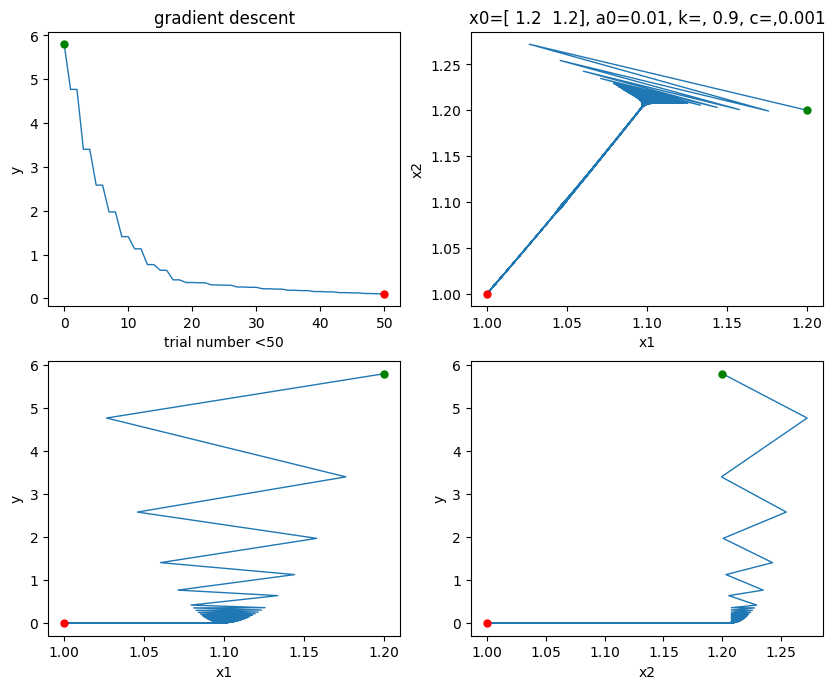

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 0.01 , k= 0.9 , c= 0.001
更新方法：gradient descent
試行回数：34142

(x1, x2)の極小解
 [ 0.99999977  0.99999955]


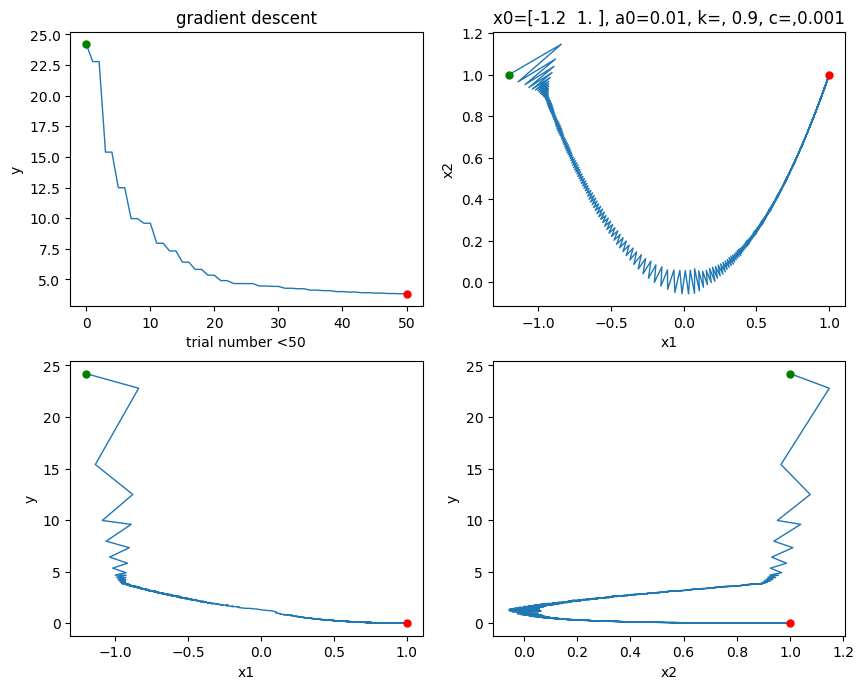

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 0.1 , k= 0.9 , c= 0.001
更新方法：gradient descent
試行回数：34296

(x1, x2)の極小解
 [ 1.00000017  1.00000033]


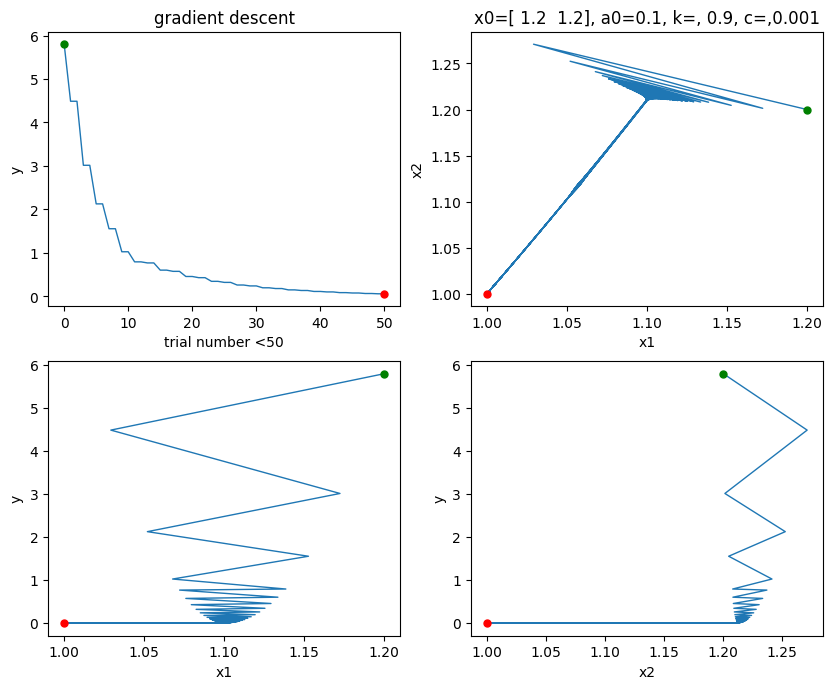

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 0.1 , k= 0.9 , c= 0.001
更新方法：gradient descent
試行回数：41658

(x1, x2)の極小解
 [ 1.00000017  1.00000033]


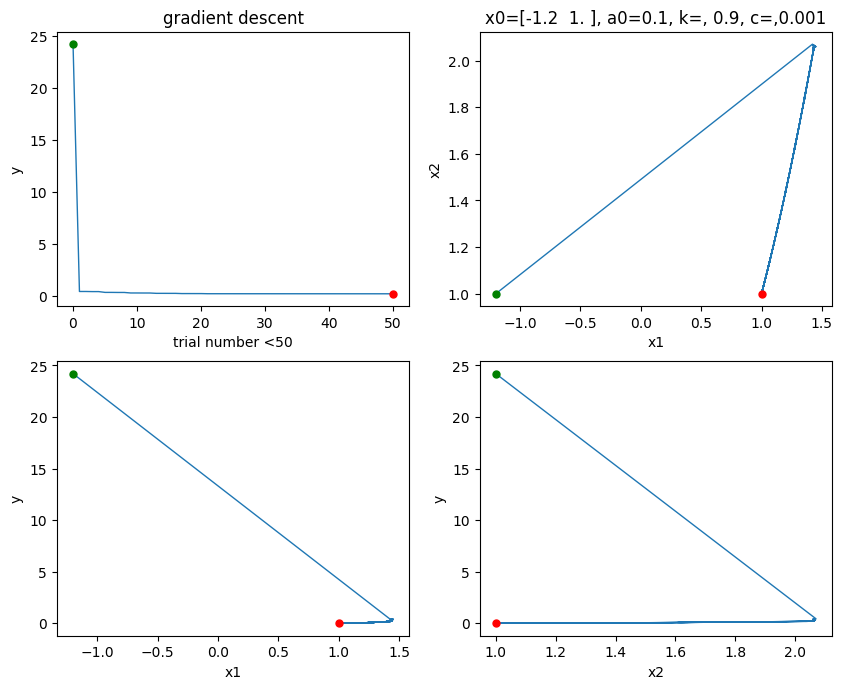

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 1 , k= 0.9 , c= 0.001
更新方法：gradient descent
試行回数：38146

(x1, x2)の極小解
 [ 1.00000004  1.00000007]


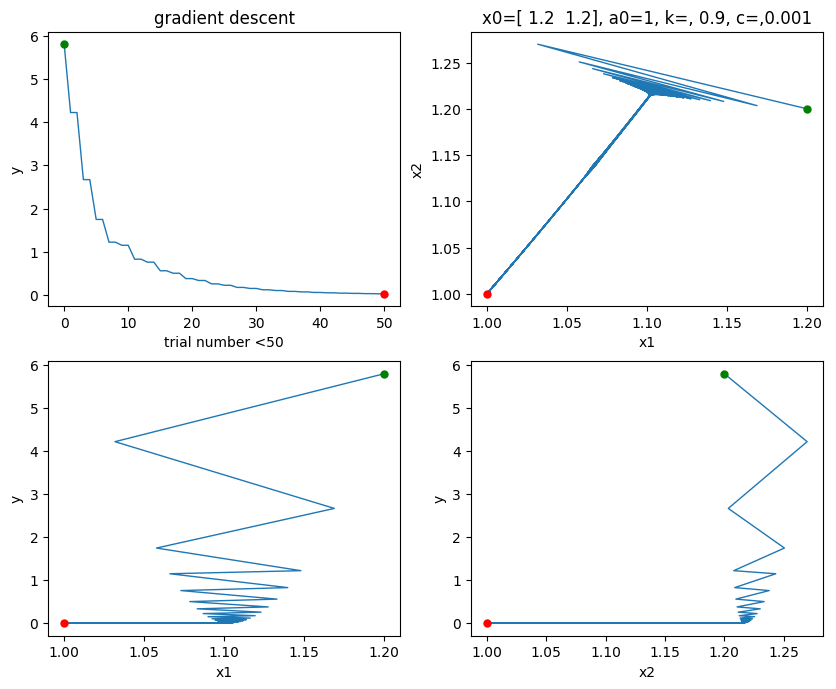

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 1 , k= 0.9 , c= 0.001
更新方法：gradient descent
試行回数：45056

(x1, x2)の極小解
 [ 1.00000004  1.00000008]


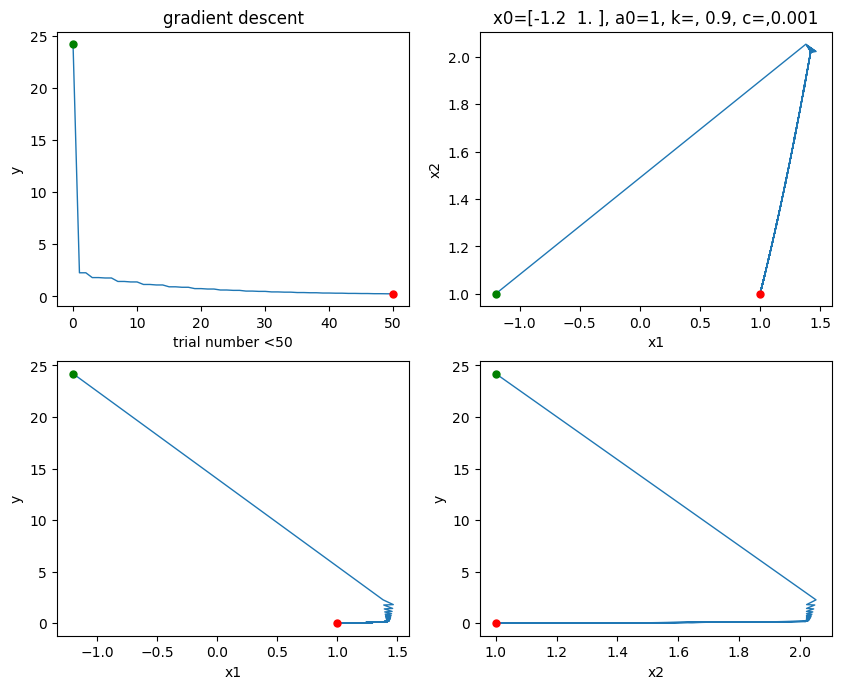

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 5 , k= 0.9 , c= 0.001
更新方法：gradient descent
試行回数：33508

(x1, x2)の極小解
 [ 1.00000022  1.00000045]


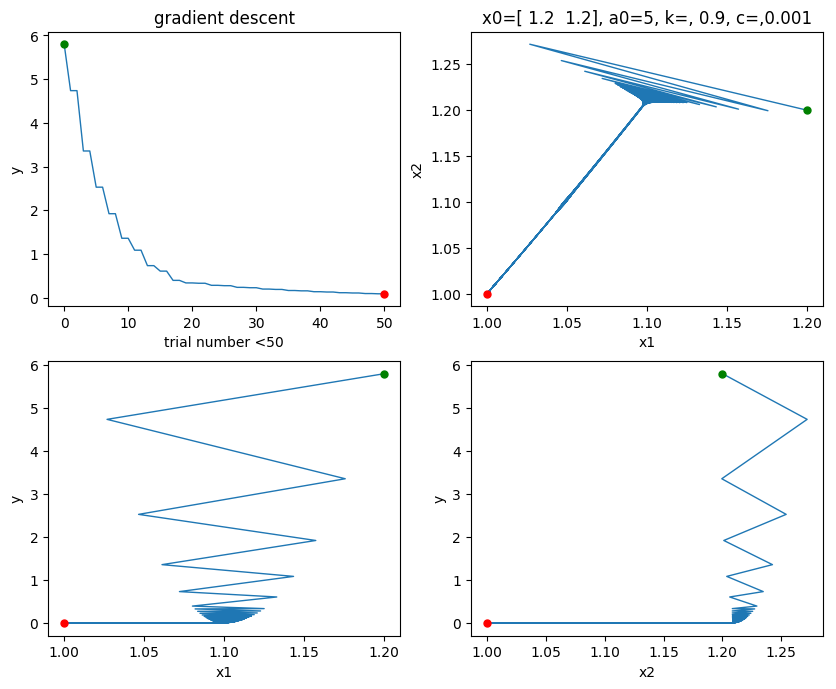

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 5 , k= 0.9 , c= 0.001
更新方法：gradient descent
試行回数：41090

(x1, x2)の極小解
 [ 1.00000022  1.00000044]


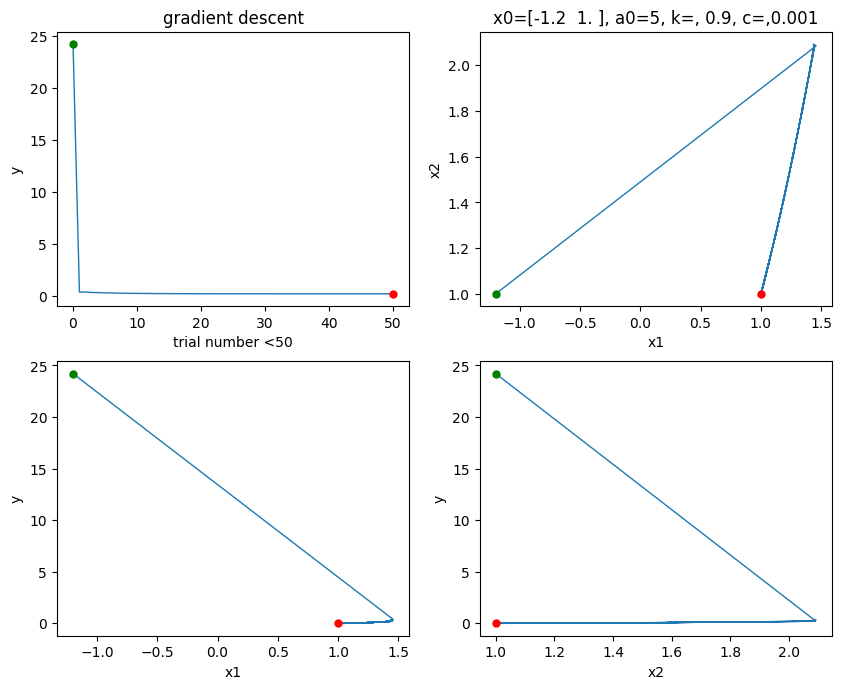

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 10 , k= 0.9 , c= 0.001
更新方法：gradient descent
試行回数：32114

(x1, x2)の極小解
 [ 1.00000033  1.00000067]


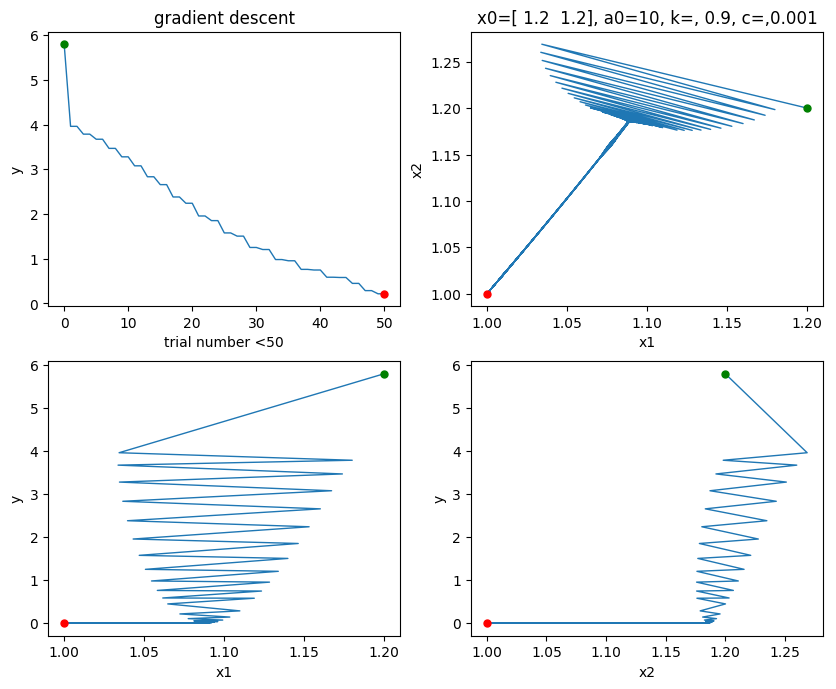

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 10 , k= 0.9 , c= 0.001
更新方法：gradient descent
試行回数：39370

(x1, x2)の極小解
 [ 1.00000033  1.00000067]


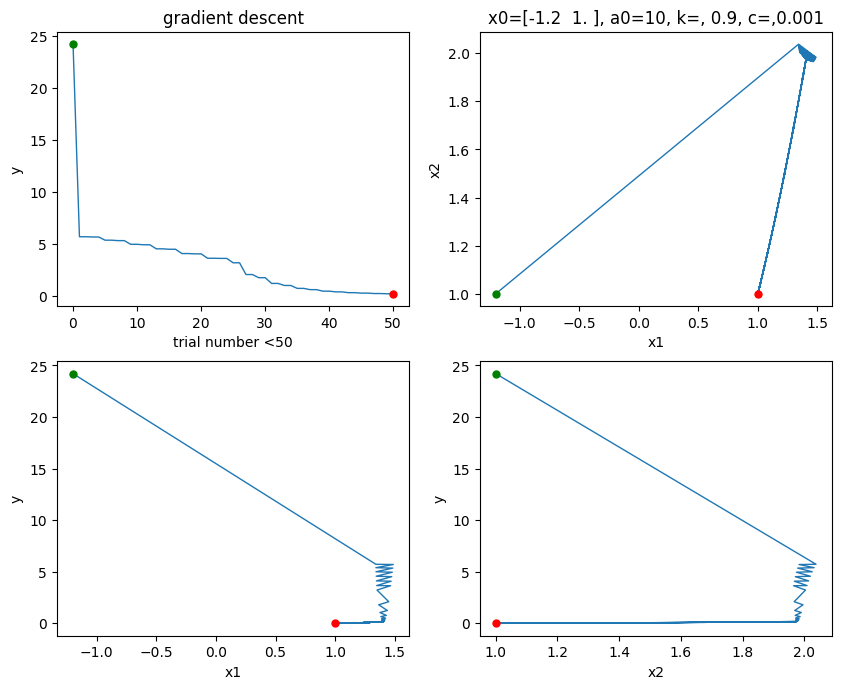

None


***ニュートン法*************************************************************************************
(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 0.01 , k= 0.9 , c= 0.001
更新方法：Newton Method
試行回数：5

(x1, x2)の極小解
 [ 1.  1.]


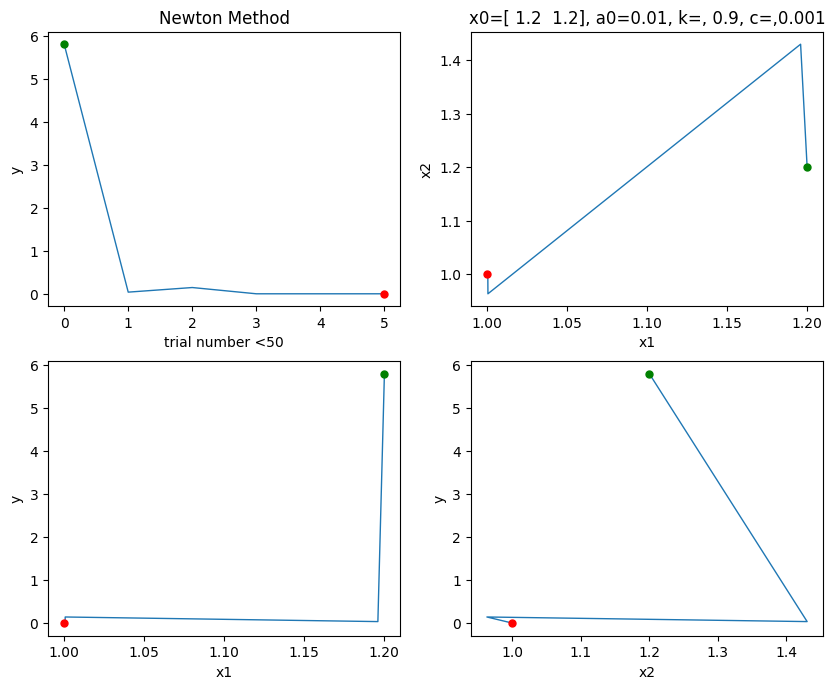

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 0.01 , k= 0.9 , c= 0.001
更新方法：Newton Method
試行回数：6

(x1, x2)の極小解
 [ 1.  1.]


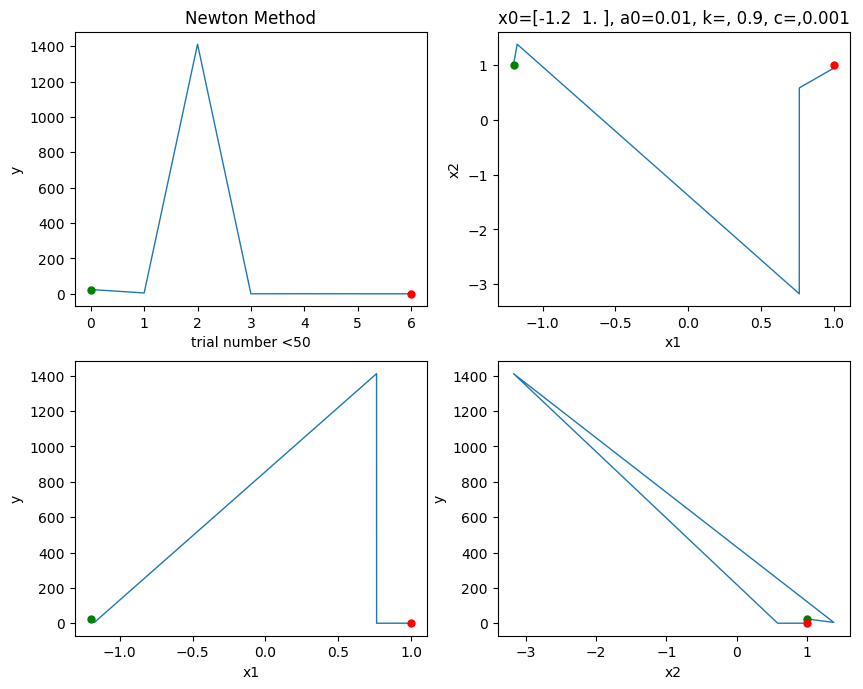

None


***B行列におけるBFGS公式の準ニュートン法************************************************************************************
(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 0.01 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, B-Matrix
試行回数：1835

(x1, x2)の極小解
 [ 1.00000004  1.00000008]


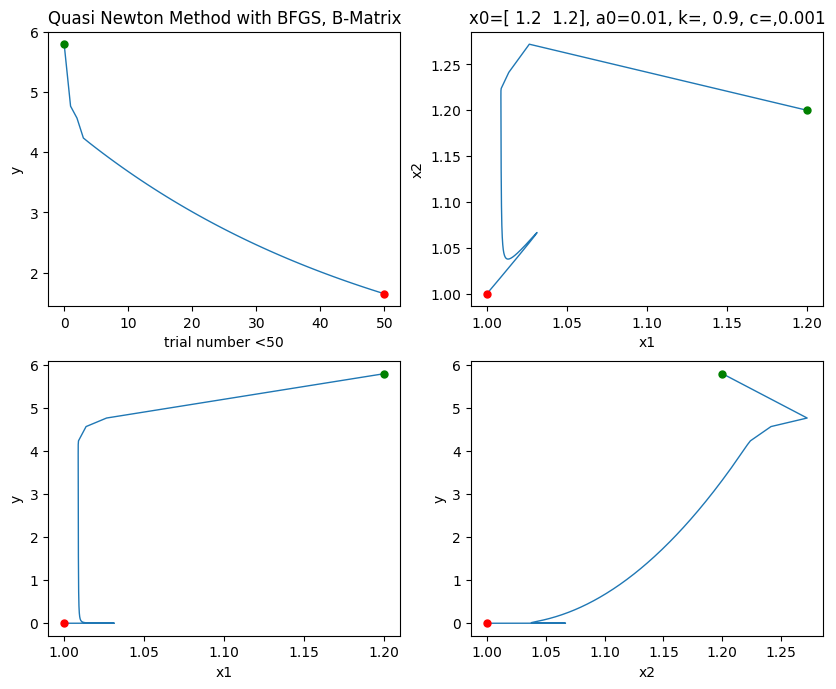

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 0.01 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, B-Matrix
試行回数：230

(x1, x2)の極小解
 [ nan  nan]


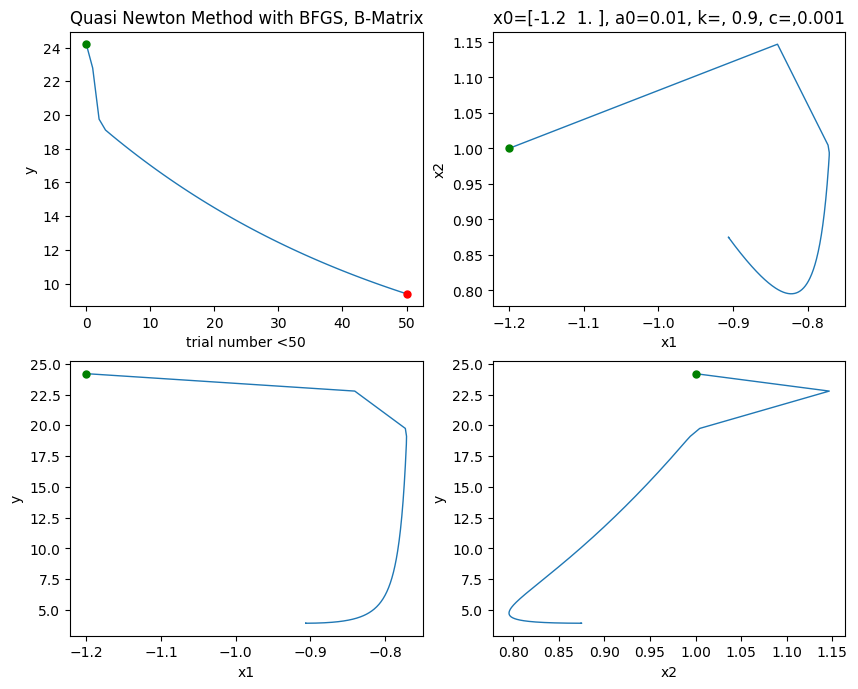

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 0.1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, B-Matrix
39回試行後xが非最適点[ 0.7720124   0.59253415]で更新停止
None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 0.1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, B-Matrix
29回試行後xが非最適点[ 1.27475971  1.62998239]で更新停止
None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, B-Matrix
試行回数：19

(x1, x2)の極小解
 [ 1.  1.]


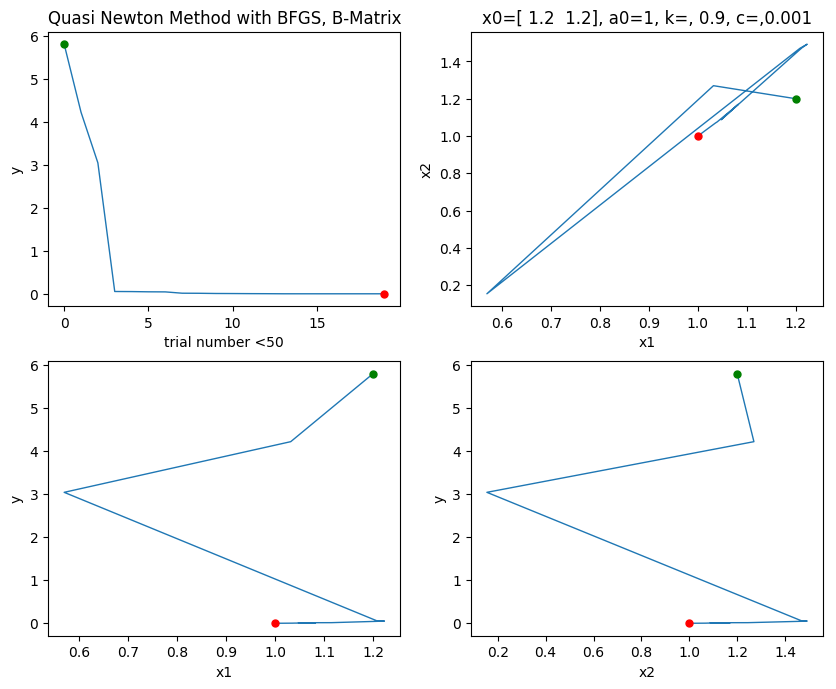

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, B-Matrix
試行回数：20

(x1, x2)の極小解
 [ 1.  1.]


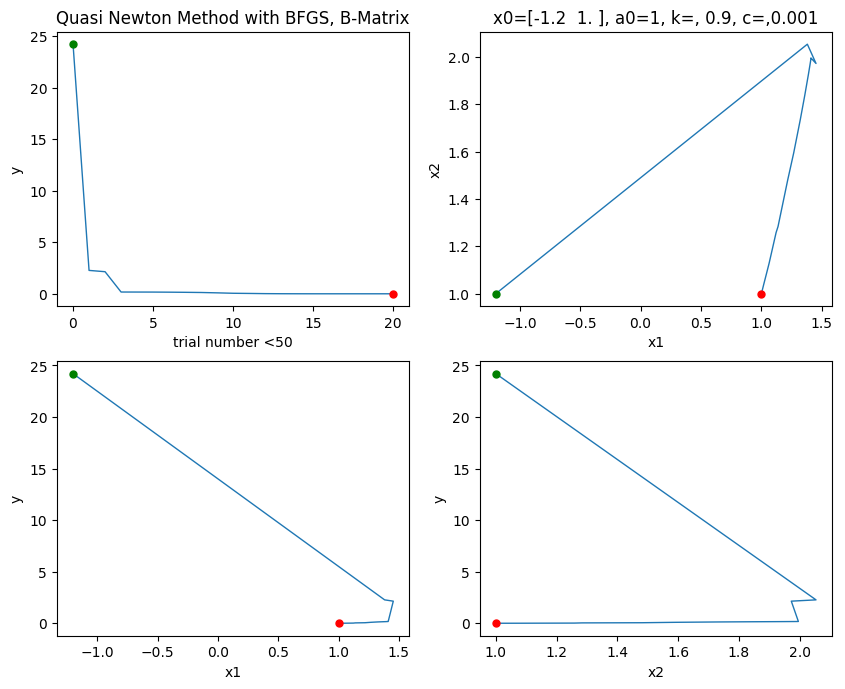

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 5 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, B-Matrix
試行回数：281

(x1, x2)の極小解
 [ 0.99999999  0.99999998]


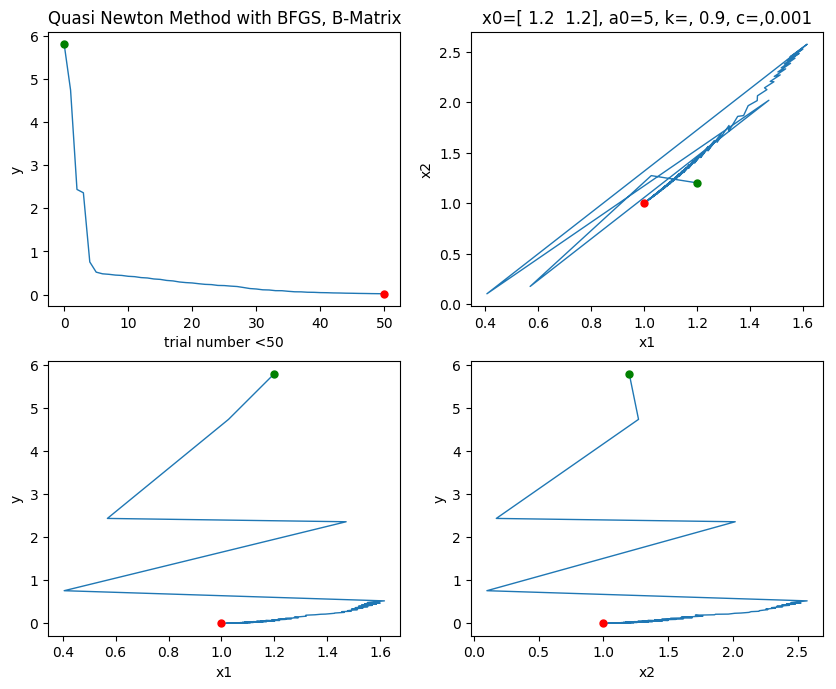

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 5 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, B-Matrix
試行回数：284

(x1, x2)の極小解
 [ 1.          1.00000001]


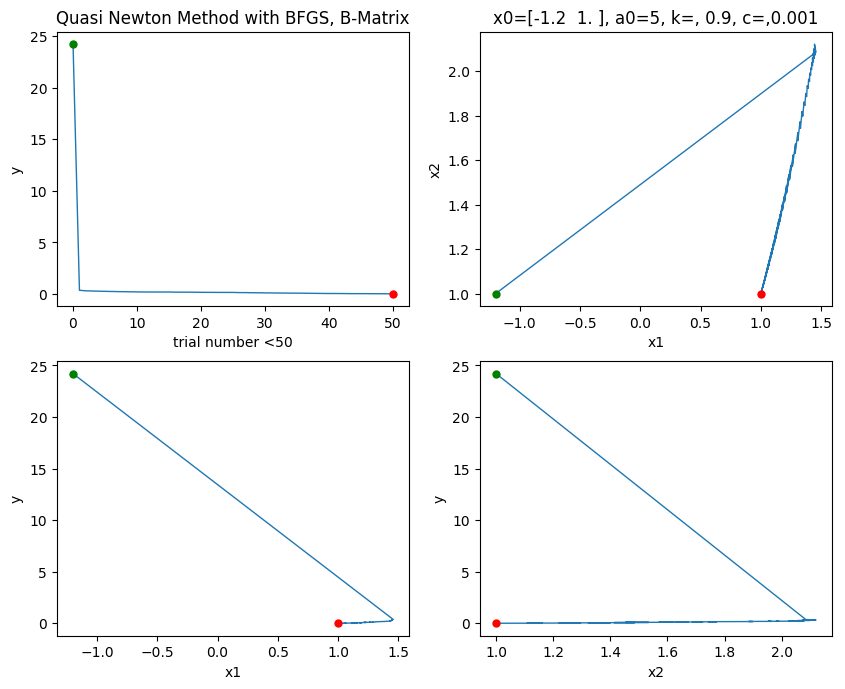

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 10 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, B-Matrix
試行回数：170

(x1, x2)の極小解
 [ 0.99999999  0.99999999]


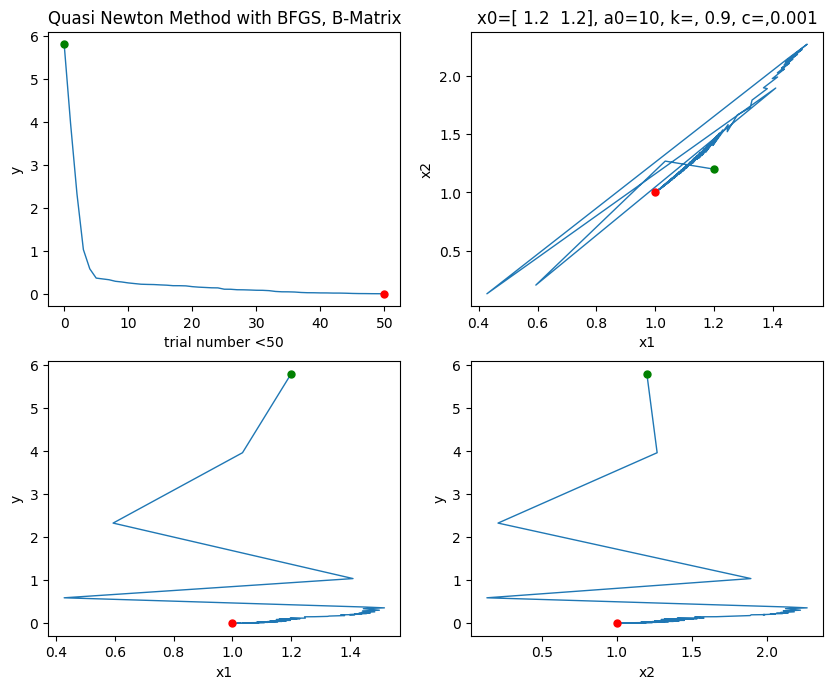

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 10 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, B-Matrix
試行回数：209

(x1, x2)の極小解
 [ 1.          1.00000001]


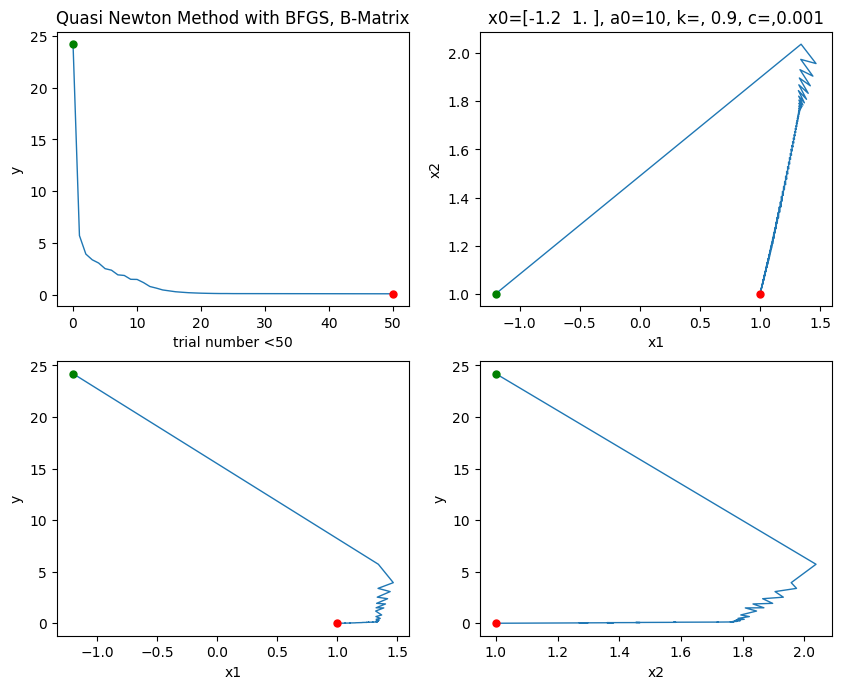

None


***B行列におけるDFP公式の準ニュートン法*************************************************************************************
(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 0.01 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, B-Matrix
398回試行後xが非最適点[ 1.03767853  1.08170596]で更新停止
None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 0.01 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, B-Matrix
試行回数：19861

(x1, x2)の極小解
 [ 0.99999947  0.99999895]


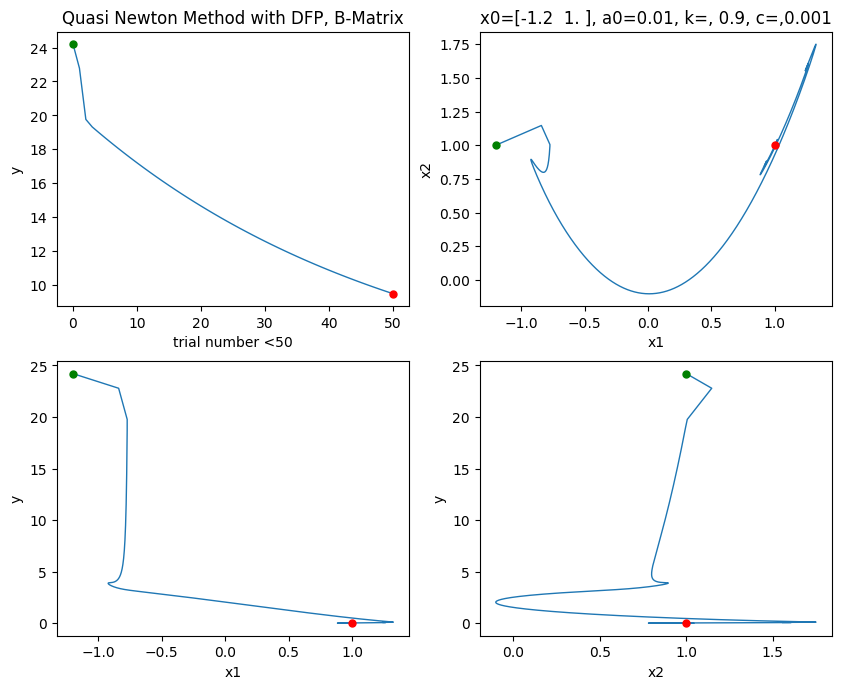

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 0.1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, B-Matrix
試行回数：2137

(x1, x2)の極小解
 [ 0.9999994   0.99999881]


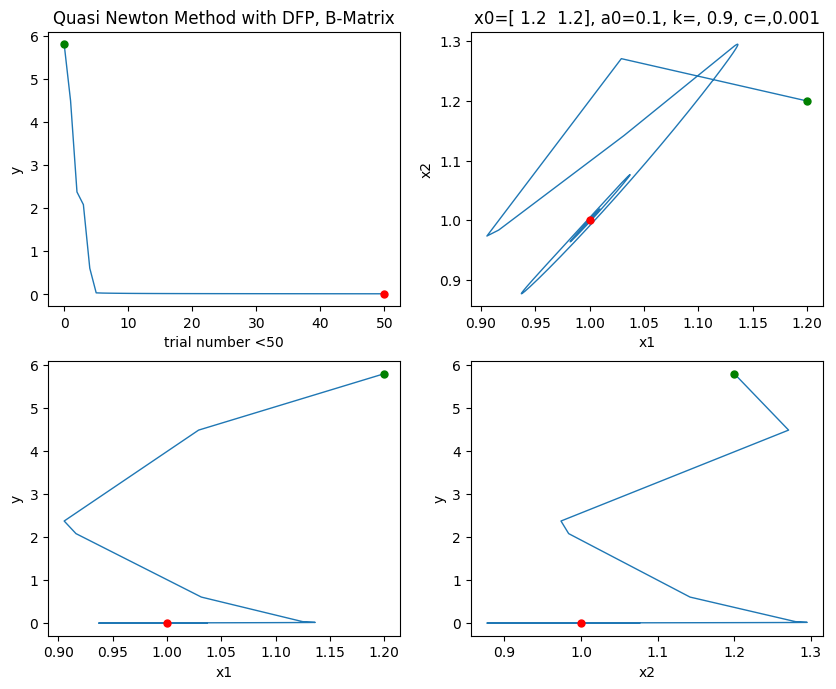

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 0.1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, B-Matrix
試行回数：752

(x1, x2)の極小解
 [ 1.00000061  1.00000122]


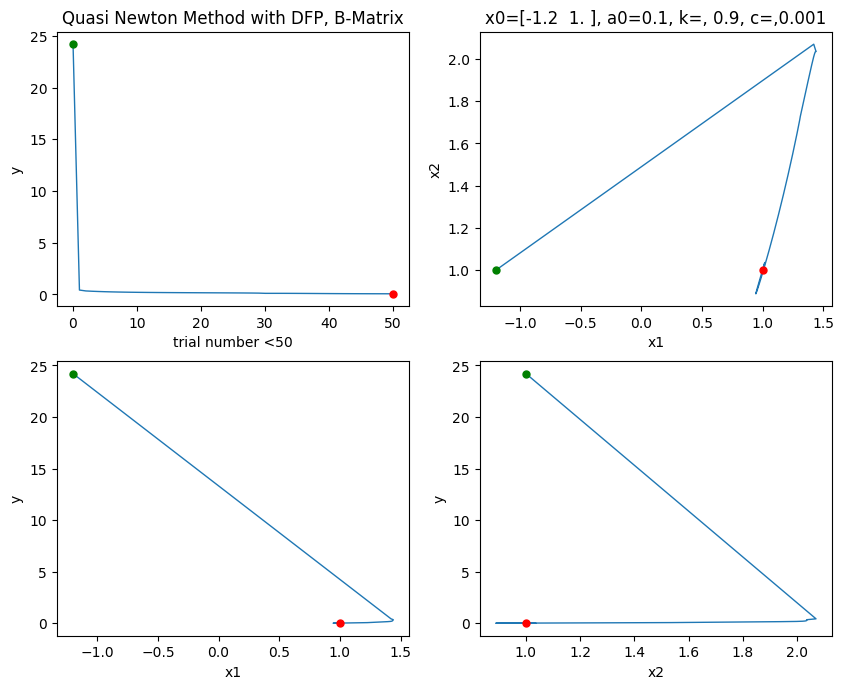

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, B-Matrix
試行回数：27

(x1, x2)の極小解
 [ 1.00000003  1.00000007]


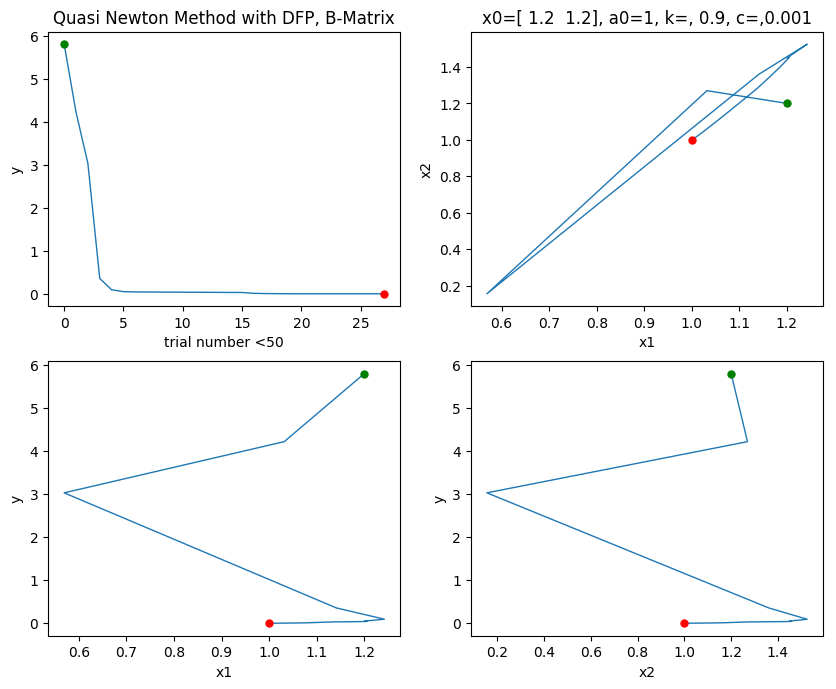

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, B-Matrix
10万回試行により暫定解[ 1.02934591  1.08403224]でタイムアウト
None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 5 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, B-Matrix
試行回数：581

(x1, x2)の極小解
 [ 0.99999997  0.99999994]


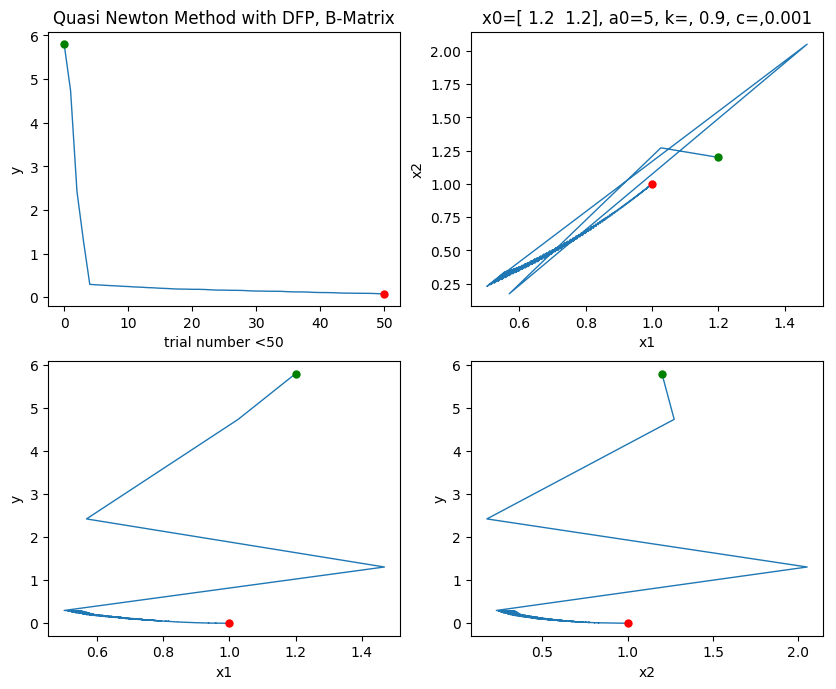

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 5 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, B-Matrix
試行回数：1778

(x1, x2)の極小解
 [ 1.00000047  1.00000094]


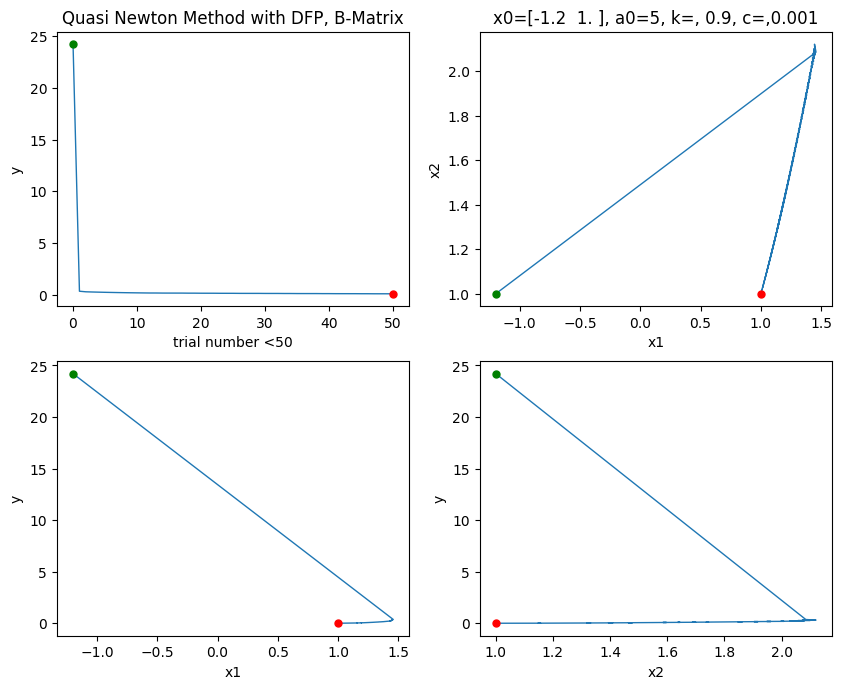

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 10 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, B-Matrix
試行回数：1016

(x1, x2)の極小解
 [ 1.00000002  1.00000003]


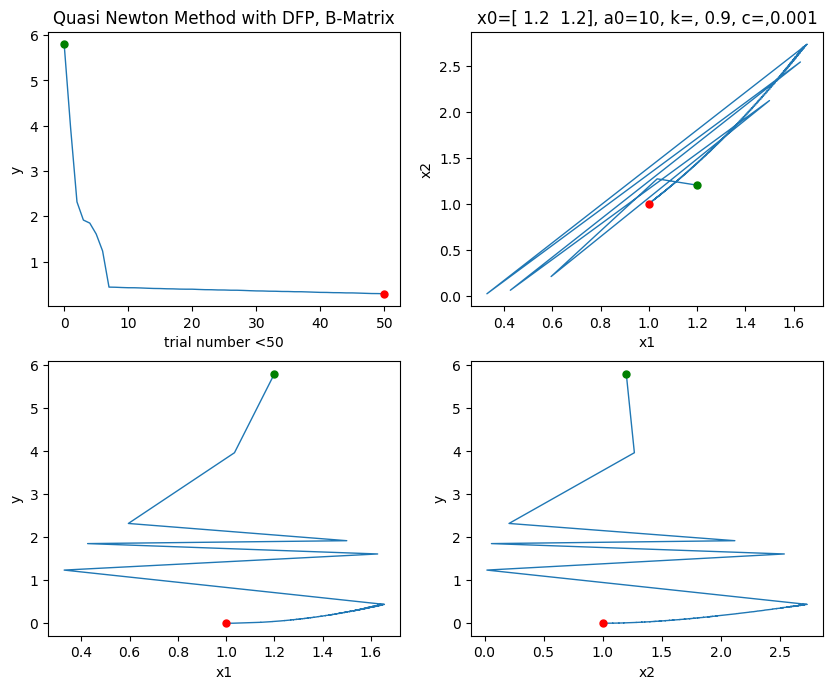

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 10 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, B-Matrix
試行回数：2923

(x1, x2)の極小解
 [ 1.00000006  1.00000012]


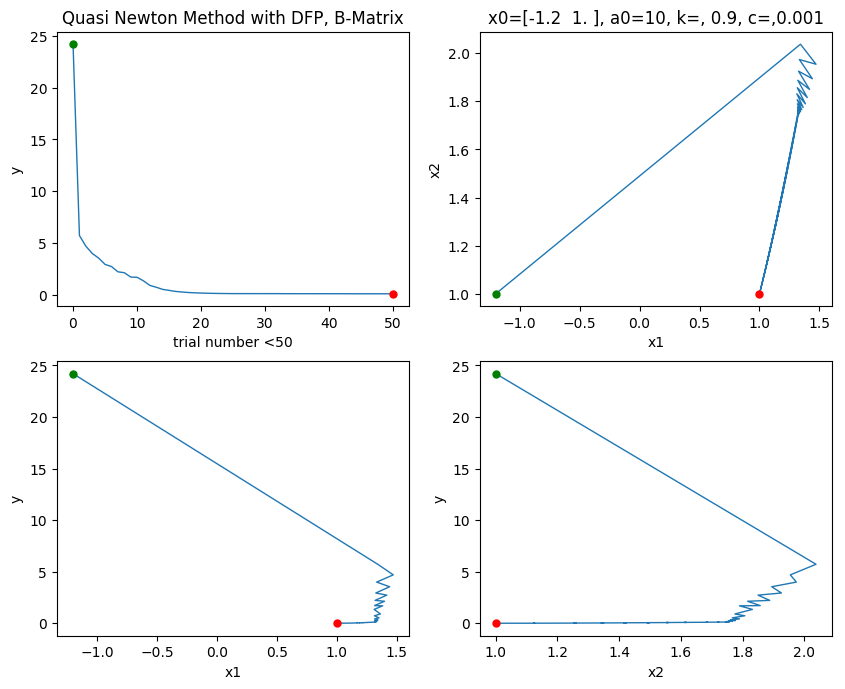

None


***H行列におけるBFGS公式の準ニュートン法*************************************************************************************
(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 0.01 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, H-Matrix
試行回数：1838

(x1, x2)の極小解
 [ 1.00000004  1.00000008]


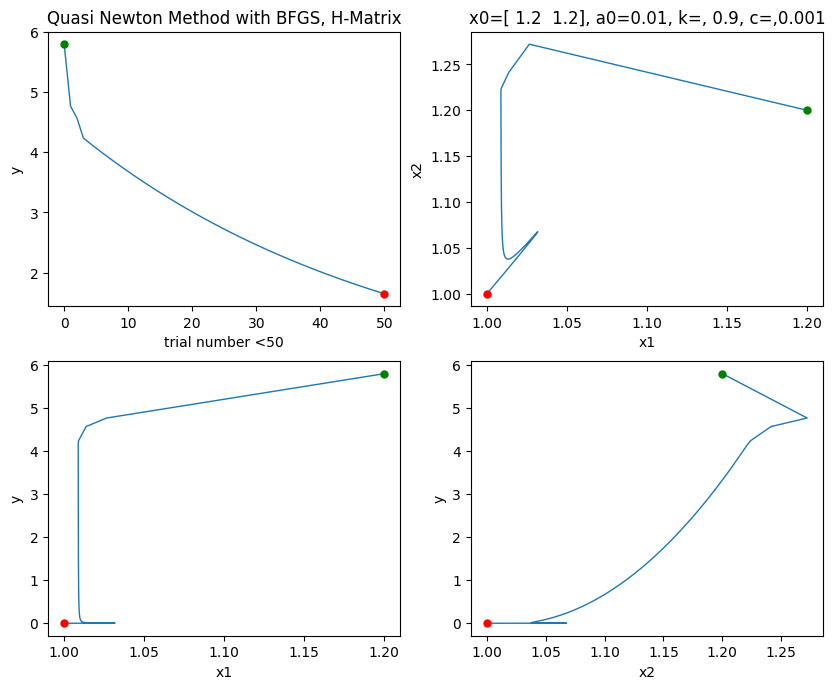

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 0.01 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, H-Matrix
試行回数：2542

(x1, x2)の極小解
 [ 0.99999932  0.99999863]


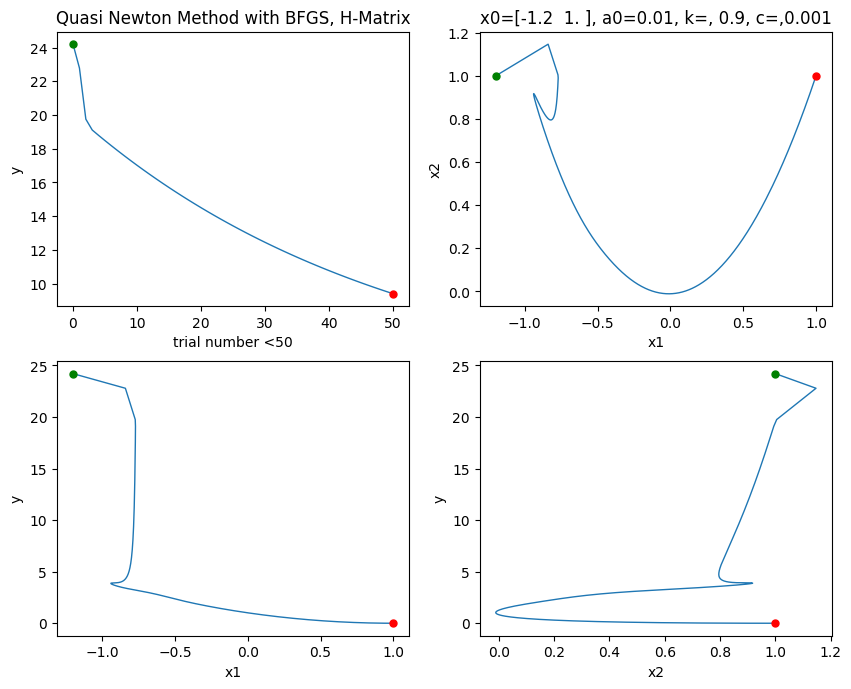

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 0.1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, H-Matrix
試行回数：213

(x1, x2)の極小解
 [ 0.99999993  0.99999985]


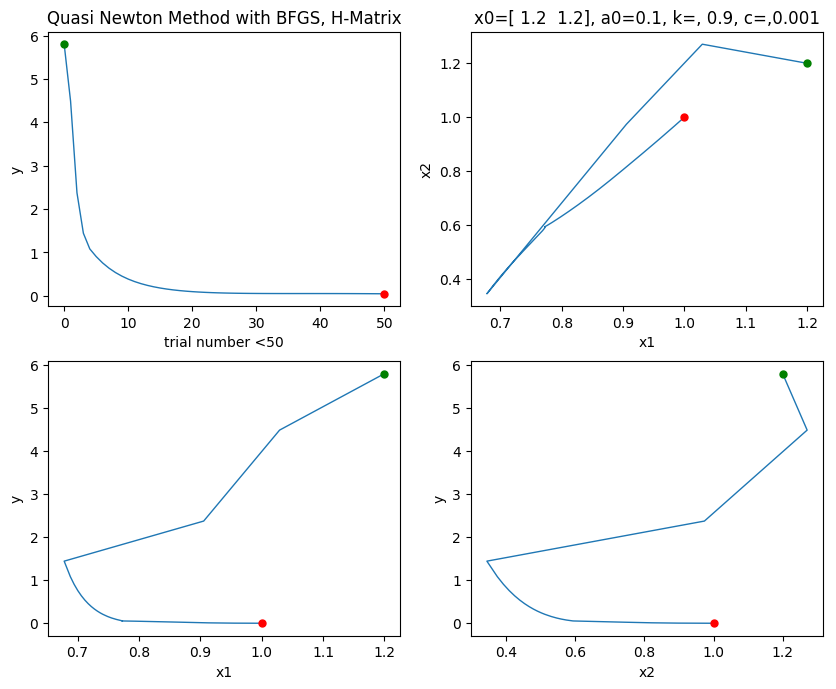

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 0.1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, H-Matrix
29回試行後xが非最適点[ 1.27475971  1.62998239]で更新停止
None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, H-Matrix
試行回数：19

(x1, x2)の極小解
 [ 1.  1.]


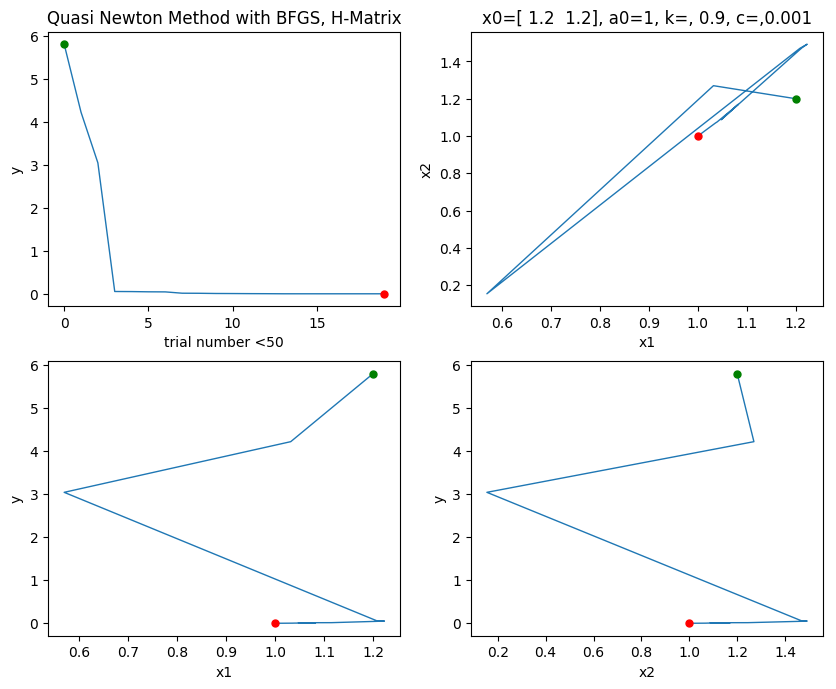

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, H-Matrix
試行回数：20

(x1, x2)の極小解
 [ 1.  1.]


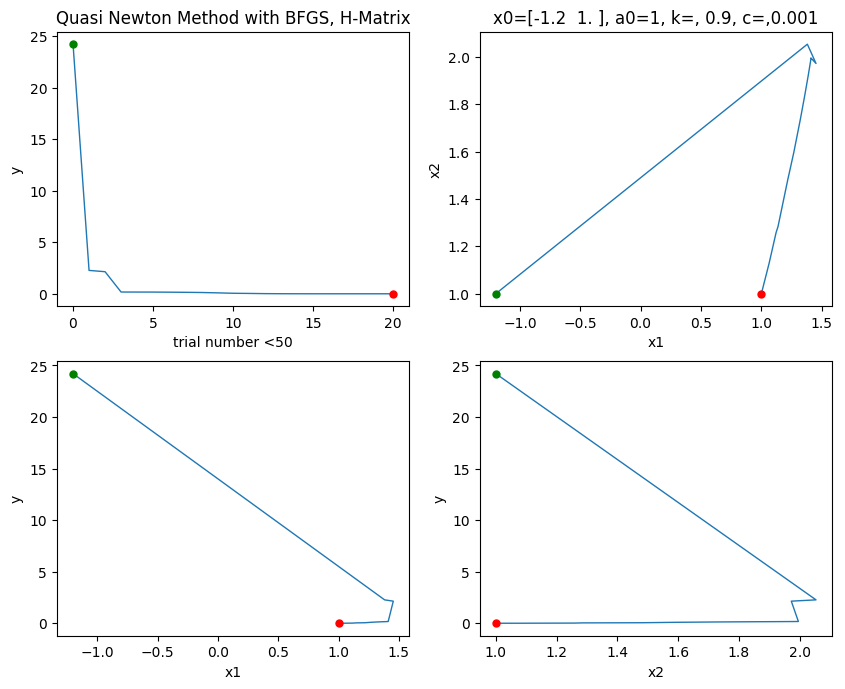

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 5 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, H-Matrix
試行回数：281

(x1, x2)の極小解
 [ 0.99999999  0.99999998]


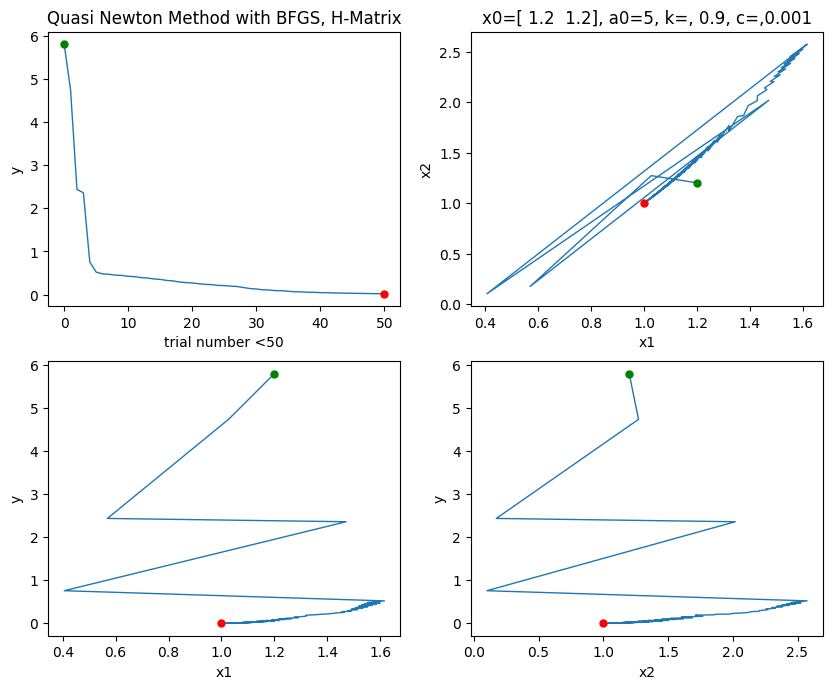

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 5 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, H-Matrix
試行回数：284

(x1, x2)の極小解
 [ 1.          1.00000001]


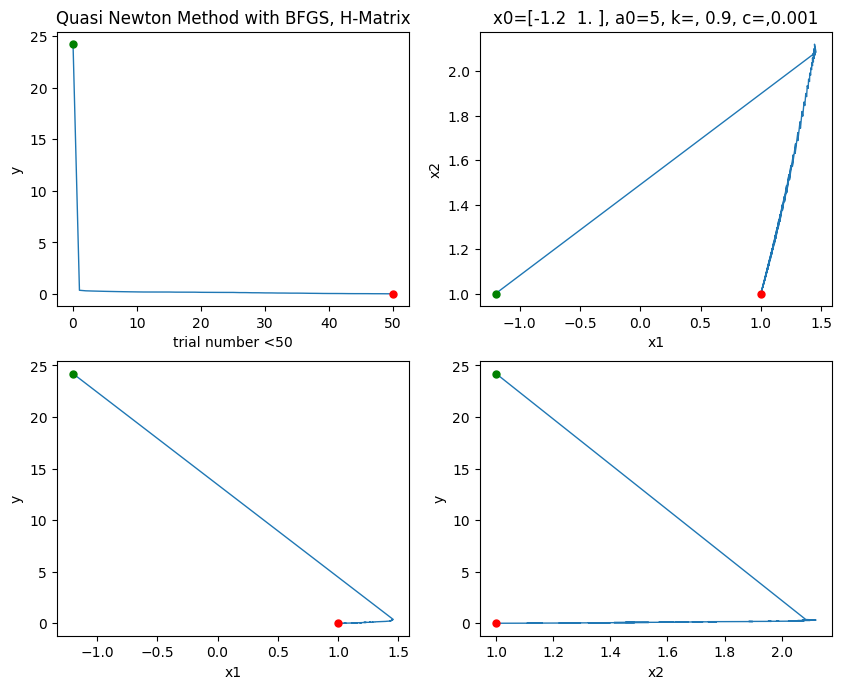

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 10 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, H-Matrix
試行回数：170

(x1, x2)の極小解
 [ 0.99999999  0.99999999]


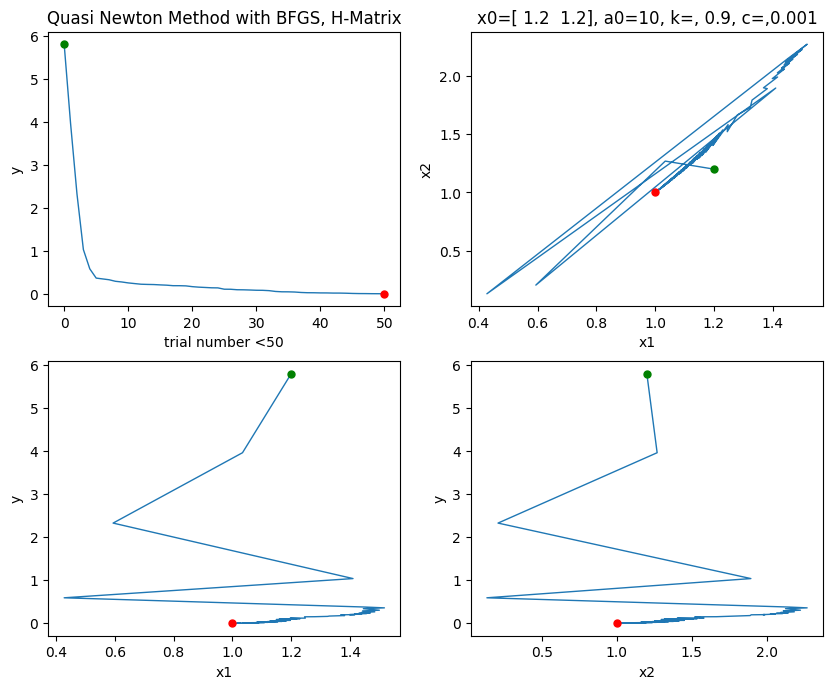

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 10 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with BFGS, H-Matrix
試行回数：209

(x1, x2)の極小解
 [ 1.          1.00000001]


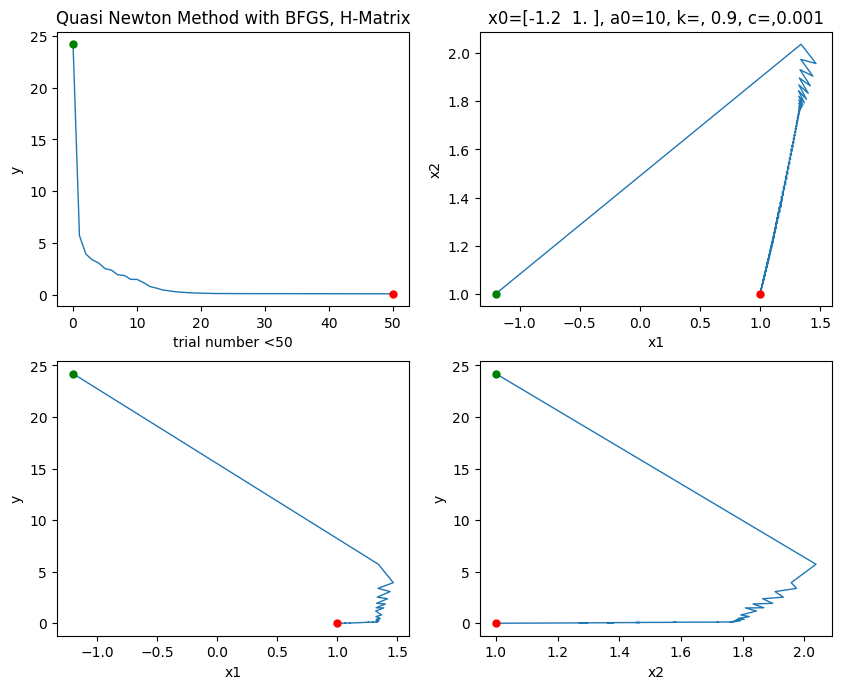

None


***H行列におけるDFP公式の準ニュートン法*************************************************************************************
(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 0.01 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, H-Matrix
399回試行後xが非最適点[ 1.03767853  1.08170596]で更新停止
None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 0.01 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, H-Matrix
225回試行後xが非最適点[-0.90709595  0.87784118]で更新停止
None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 0.1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, H-Matrix
試行回数：2137

(x1, x2)の極小解
 [ 0.9999994   0.99999881]


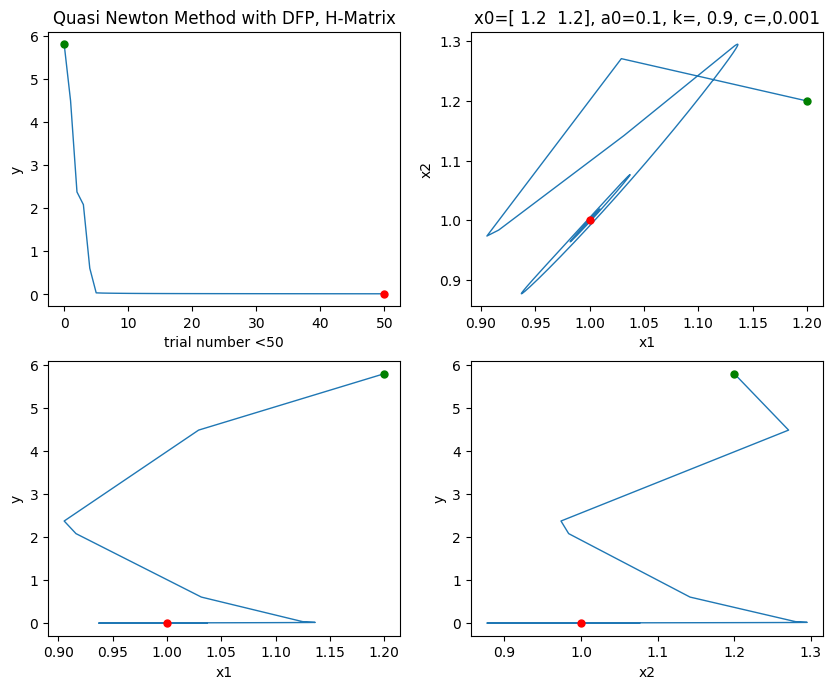

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 0.1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, H-Matrix
試行回数：3701

(x1, x2)の極小解
 [ 0.99999943  0.99999886]


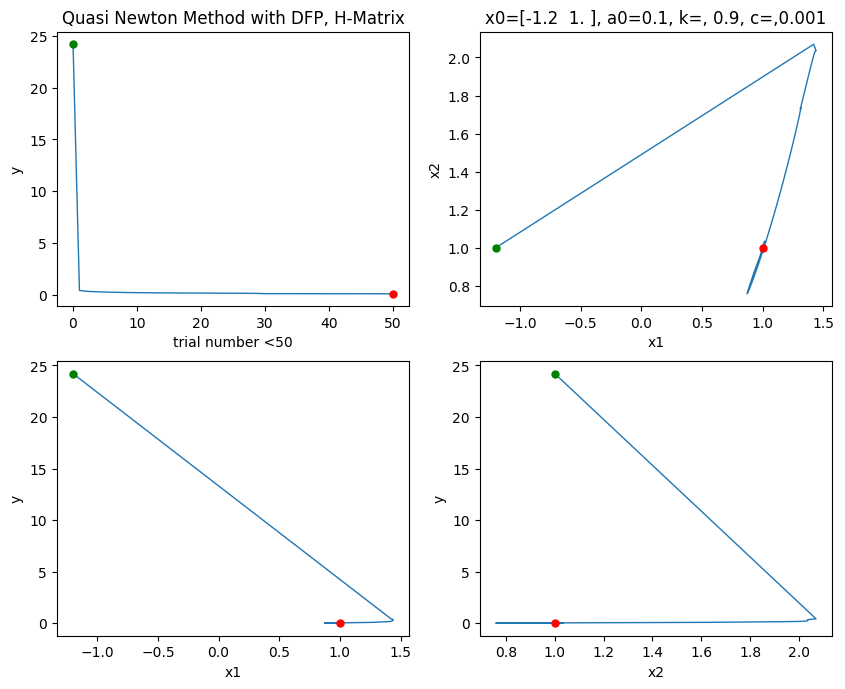

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, H-Matrix
試行回数：27

(x1, x2)の極小解
 [ 1.00000003  1.00000007]


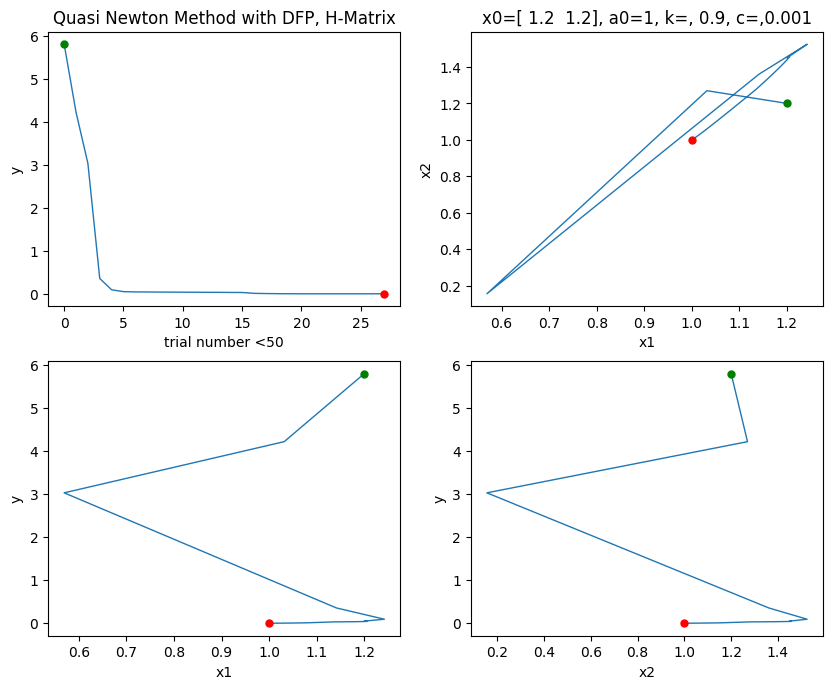

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 1 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, H-Matrix
41回試行後xが非最適点[ 1.28215169  1.65441318]で更新停止
None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 5 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, H-Matrix
試行回数：573

(x1, x2)の極小解
 [ 0.99999996  0.99999993]


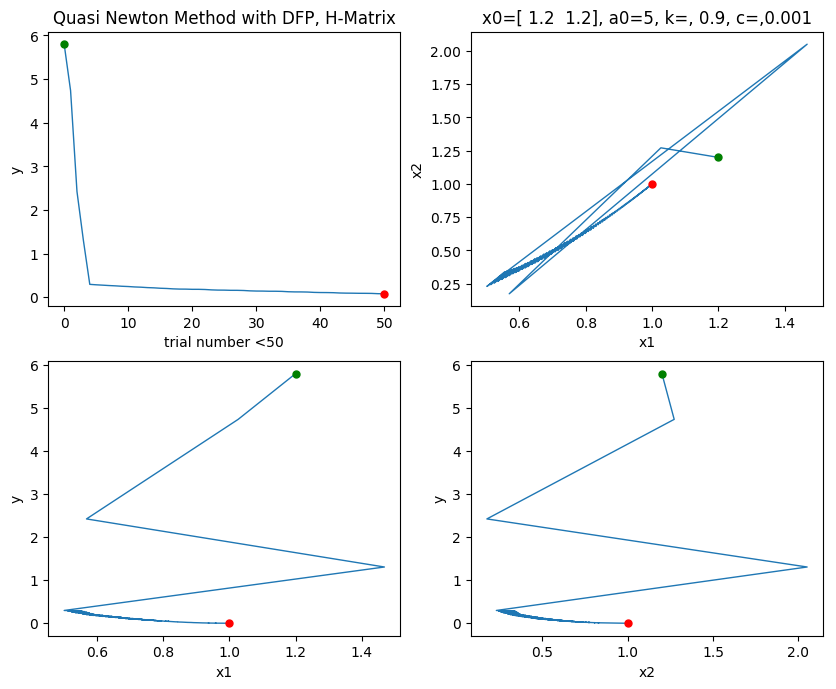

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 5 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, H-Matrix
試行回数：1832

(x1, x2)の極小解
 [ 1.00000032  1.00000064]


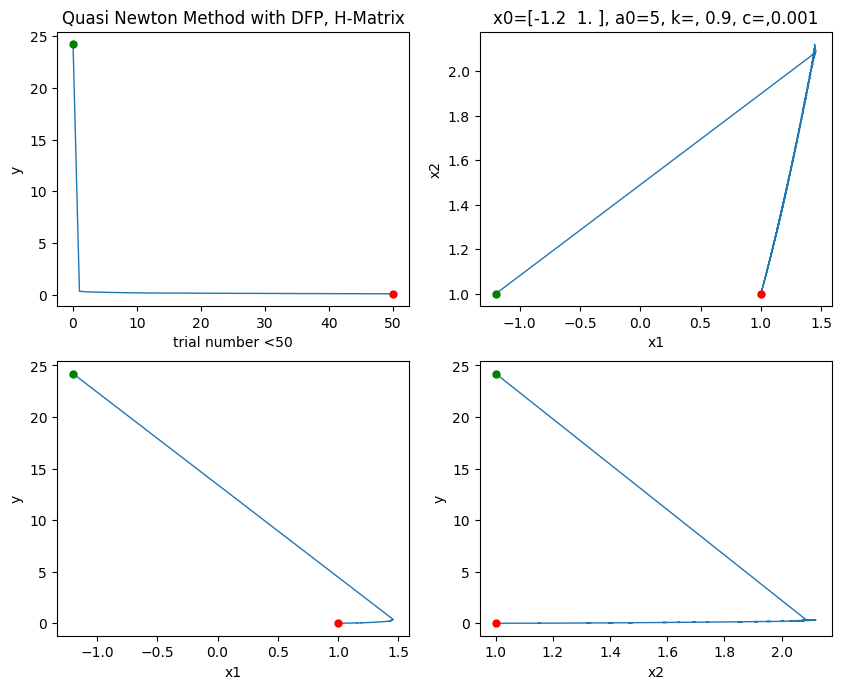

None


(x1, x2) = [ 1.2  1.2] のとき********************************
a0= 10 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, H-Matrix
試行回数：1404

(x1, x2)の極小解
 [ 1.00000009  1.00000018]


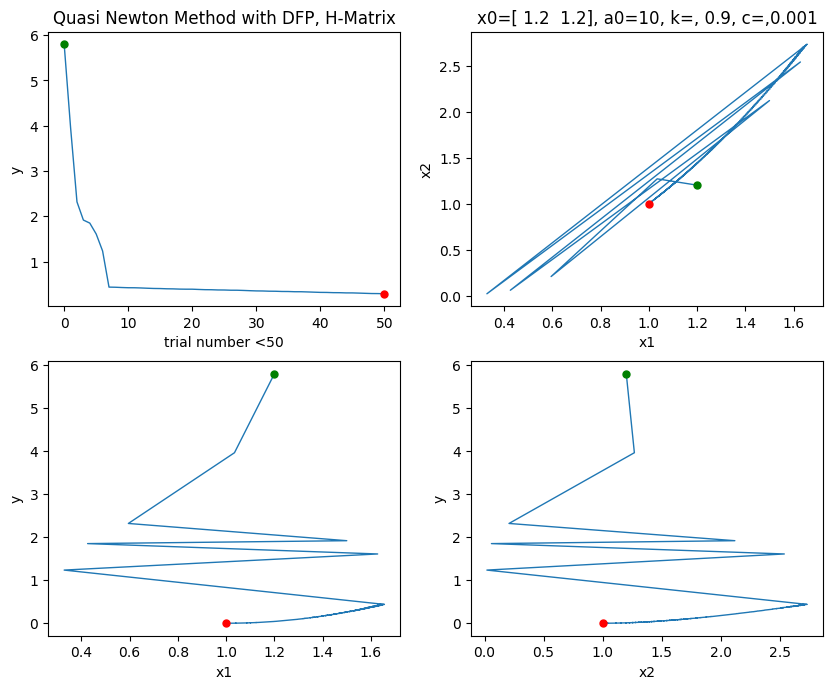

None


(x1, x2) = [-1.2  1. ] のとき********************************
a0= 10 , k= 0.9 , c= 0.001
更新方法：Quasi Newton Method with DFP, H-Matrix
試行回数：2993

(x1, x2)の極小解
 [ 1.00000007  1.00000014]


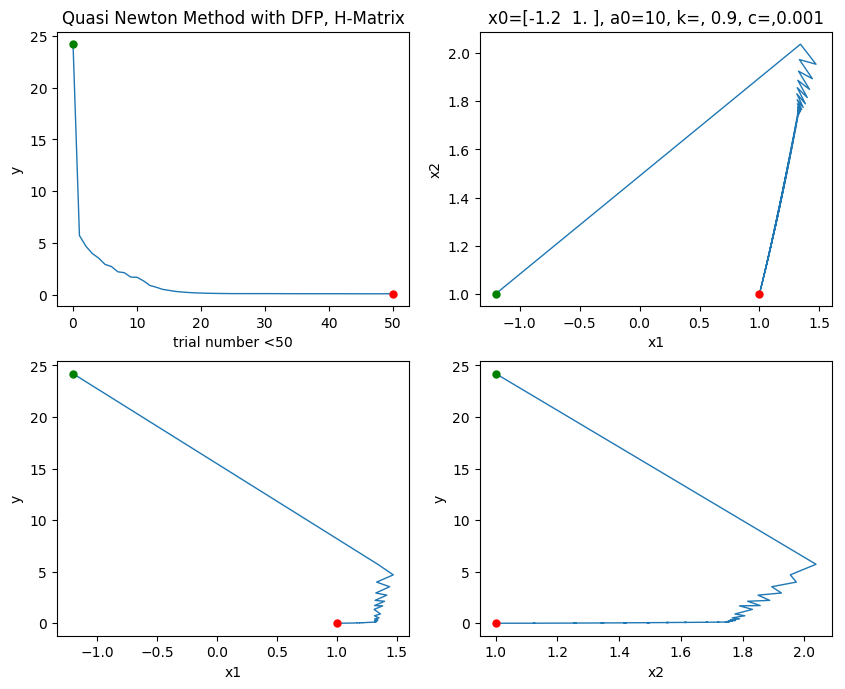

None




In [30]:
#各計算法で試行した全てのパラメータにつき、プロット
print("***最急降下法*************************************************************************************")
result_plot_each(list_solutions_gradient_descent, "gradient descent")

print("***ニュートン法*************************************************************************************")
result_plot_each(list_solutions_newton_method, "Newton Method")

print("***B行列におけるBFGS公式の準ニュートン法************************************************************************************")
result_plot_each(list_solutions_quasi_newton_method_bfgs_b, "Quasi Newton Method with BFGS, B-Matrix")

print("***B行列におけるDFP公式の準ニュートン法*************************************************************************************")
result_plot_each(list_solutions_quasi_newton_method_dfp_b, "Quasi Newton Method with DFP, B-Matrix")

print("***H行列におけるBFGS公式の準ニュートン法*************************************************************************************")
result_plot_each(list_solutions_quasi_newton_method_bfgs_h, "Quasi Newton Method with BFGS, H-Matrix")

print("***H行列におけるDFP公式の準ニュートン法*************************************************************************************")
result_plot_each(list_solutions_quasi_newton_method_dfp_h, "Quasi Newton Method with DFP, H-Matrix")